# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Importing libraries

In [45]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import time
# magic word for producing visualizations in notebook
%matplotlib inline

#scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Loading data

While loading in the data I got a warning: `DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)`

In [46]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')



C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
attribuets_desc = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

I want to check the shape of the datasets and additional documents.

In [48]:
print('Azdias shape: ', azdias.shape)
print('Customers shape: ', customers.shape)
print('DIAS Attributes shape: ', attributes_values.shape)
print('DIAS Information Levels shape: ', attribuets_desc.shape)

Azdias shape:  (891221, 366)
Customers shape:  (191652, 369)
DIAS Attributes shape:  (2258, 5)
DIAS Information Levels shape:  (313, 5)


The description to the project mentioned that the "CUSTOMERS" file contains three extra columns. Thus, I want to check if this true.

In [49]:
print(customers.columns.symmetric_difference(azdias.columns))

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')


Earlier, I've got a warning, which means that some columns store in mixed-types. Therefore, before diving deeper into the analysis of the datasets, firstly,  I want to validate columns and fix the error. 
1. Checking data and source of warning

In [50]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


I want to know how does columns 18 and 19 look like and if there might be other columns with similar source of risk.

In [51]:
customers[customers.columns[customers.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
...,...,...,...,...,...,...,...,...
191647,1C,1,14,D19_BANKEN_REST,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191648,5B,5,32,D19_UNBEKANNT,1997-03-06 00:00:00,W,COSMETIC,SINGLE_BUYER
191649,4D,4,24,D19_TECHNIK,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191650,4C,4,24,D19_BANKEN_REST,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER


Here I want to verify what might be a cause of the problem.

In [52]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [53]:
print('Customers (18, 19): - ', customers.iloc[:, 18:20].columns)
print('Azdias (18, 19): - ', azdias.iloc[:, 18:20].columns)
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

Customers (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Azdias (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


CAMEO_DEUG_2015
1.0     4280
2.0     5910
3.0     4805
4.0     5606
5.0     3042
6.0     4709
7.0     2680
8.0     3333
9.0     1661
1      12498
2      17574
3      13585
4      16458
5       8624
6      14008
7       7878
8       9716
9       4731
X        126
Name: CAMEO_DEUG_2015, dtype: int64

The problem of mixed types in columns is because there is actually a mix of float, int and string values. 
I assume that int anf float (e.g,: 12.0 and 12) represent the same criterea. Therefore, I will perform formating (float => int, X/XX => NaN)

In [54]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0      924
13.0     1955
14.0     4939
15.0     2372
22.0     1941
23.0     1494
24.0     4504
25.0     2472
31.0      681
32.0      440
33.0      396
34.0     1423
35.0      553
41.0     2859
43.0     2476
44.0      688
45.0     1352
51.0     2126
52.0      253
54.0     1258
55.0      920
12       2791
13       5728
14      14708
15       6845
22       5566
23       4276
24      13301
25       6900
31       2050
32       1256
33       1178
34       3945
35       1741
41       8461
43       7158
44       2144
45       3936
51       5987
52        770
54       3537
55       2794
XX        126
Name: CAMEO_INTL_2015, dtype: int64

Similar situatiation with AZDIAS dataframe.

In [55]:
azdias[azdias.columns[azdias.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [56]:
def format_mixed_types(df):
    '''This function is created for formating improper 
    values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
    Args:
    df: demographics dataframe
    returns: transformed dataframe
    '''
    
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    if set(cols_nan).issubset(df.columns):
        df[cols_nan] = df[cols_nan].replace({'X': np.nan, 'XX': np.nan})
        df[cols] = df[cols].astype(float)

    return df

In [57]:
customers = format_mixed_types(customers)

In [58]:
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

Now we do not have a mixture of different data types, and values from float and int are properly merged. 

In [59]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [60]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D'], dtype=object)

In [61]:
azdias = format_mixed_types(azdias)

### 0.2 Checking attributes

After, we are finished with warning-problem, I would like to have a quick look on the attributes files.

In [62]:
attribuets_desc.drop(columns=['Unnamed: 0'], inplace=True)
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
attribuets_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [64]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


From the observations I may conclude that those dataframes contain descriptions for each column name in AZDIAS and CUSTOMERS files as well as the range of the proper values.

In [65]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


At this point, I want to check what is common for all given datafiles.

In [66]:
customers_unique = set(list(customers.columns))
azdias_unique = set(list(azdias.columns))
attribuets_desc_unique = set(list(attribuets_desc.Attribute))
attributes_values_unique = set(list(attributes_values.Attribute))

print('No of columns in CUSTOMESRS: ', len(customers_unique))
print('No of columns in AZDIAS: ', len(azdias_unique))
print('No of columns in Attributes description: ', len(attribuets_desc_unique))
print('No of columns in Attributes values: ', len(attributes_values_unique))

common = customers_unique & azdias_unique & attribuets_desc_unique
print('No of columns in common: ', len(common))

No of columns in CUSTOMESRS:  369
No of columns in AZDIAS:  366
No of columns in Attributes description:  313
No of columns in Attributes values:  314
No of columns in common:  264


### 0.3  Missing values

While observing the Attributes values, CUSTOMERS and AZDIAS dataframes I have mentioned that by now there are 3 types of the missing data:
1. NaN that are already present in the dataframe
2. X and XX values in columns 18 and 19, that we have already handeled
3. In the `DIAS Attributes - Values 2017.xlsx` file in the column `Value` there are corresponding encoding for the `unknown` values

Therefore, I want to know all encoding for the unknown vlues of ecah column of dataset. For this purpose I have created the dictionary, where key is name of the column and the value is an unknown encoding. After, I retrieved all necessary information,I can perform missing value replacement (for each entry in dictionary I will check dataframe where column equals key and if such column contains values such as value of the dictionary under current key I will replace this value of the dataframe with numpy.nan.

In [67]:
'''This dictionary stores the encoding values of the unknowns for each column of the dataset'''
dict_of_unknown_names = {}
for i, row in attributes_values.iterrows():
    if "unknown" in str(row['Meaning']):
        dict_of_unknown_names[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]
print(dict_of_unknown_names)

{'AGER_TYP': [-1], 'ALTERSKATEGORIE_GROB': [-1, 0], 'ALTER_HH': [0], 'ANREDE_KZ': [-1, 0], 'BALLRAUM': [-1], 'BIP_FLAG': [-1], 'CAMEO_DEUG_2015': [-1], 'CAMEO_DEUINTL_2015': [-1], 'CJT_GESAMTTYP': [0], 'D19_KK_KUNDENTYP': [-1], 'EWDICHTE': [-1], 'FINANZTYP': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_VORSORGER': [-1], 'GEBAEUDETYP': [-1, 0], 'GEOSCORE_KLS7': [-1, 0], 'HAUSHALTSSTRUKTUR': [-1, 0], 'HEALTH_TYP': [-1], 'HH_EINKOMMEN_SCORE': [-1, 0], 'INNENSTADT': [-1], 'KBA05_ALTER1': [-1, 9], 'KBA05_ALTER2': [-1, 9], 'KBA05_ALTER3': [-1, 9], 'KBA05_ALTER4': [-1, 9], 'KBA05_ANHANG': [-1, 9], 'KBA05_ANTG1': [-1], 'KBA05_ANTG2': [-1], 'KBA05_ANTG3': [-1], 'KBA05_ANTG4': [-1], 'KBA05_AUTOQUOT': [-1, 9], 'KBA05_BAUMAX': [-1, 0], 'KBA05_CCM1': [-1, 9], 'KBA05_CCM2': [-1, 9], 'KBA05_CCM3': [-1, 9], 'KBA05_CCM4': [-1, 9], 'KBA05_DIESEL': [-1, 9], 'KBA05_FRAU': [-1, 9], 'KBA05_GBZ': [-1, 0], 'KBA

In [68]:
def replace_unknown_with_nan(df, dictionary):
    '''This function accept a dataframe which is 
    going to be check for the missing values accorfing 
    to the dictionary and if such exists it will be replaced with numpy.nan.
    Args:
    df: demographics dataframe
    dictionary: dictionary which contains encodings for unknown values for each column of the dataset
    returns: none
    '''
    for key, value in dictionary.items():
        #print(key, value)
        if key in df.columns:
            for i in range(0, len(value)):
                df.loc[df[key] == value[i], key] = np.nan




In [69]:
filtered_customers = customers.copy()
filtered_azdias = azdias.copy()
replace_unknown_with_nan(filtered_customers, dict_of_unknown_names)
replace_unknown_with_nan(filtered_azdias, dict_of_unknown_names)

Now, we will have a look on quantity of NaN values before and after the implementation of the replace_unknown_with_nan().

In [70]:
print('Pre-filtered Cusmomer df, no of NaN values: ',customers.isna().sum().sum())
print('Post-filtered Cusmomer df, no of actual NaN values: ', filtered_customers.isna().sum().sum())

print('Pre-filtered Azdias df, no of NaN values: ', azdias.isna().sum().sum())
print('Post-filtered Azdias df, no of actual NaN values: ', filtered_azdias.isna().sum().sum())
#filtered_customers.head()

Pre-filtered Cusmomer df, no of NaN values:  13864900
Post-filtered Cusmomer df, no of actual NaN values:  14488847
Pre-filtered Azdias df, no of NaN values:  33494042
Post-filtered Azdias df, no of actual NaN values:  37088636


In [71]:
adzias = None
customers = None

### 0.4 Outliers

I want to verify if there are some outliers or improper values that I am supposed to drop. In the DIAS Attributes - Values 2017.xlsx files there are descriptions for the each value, so that is how I can obtain the range of proper values. Everyting which is beyond those descriptions I may consider as incorrect values and shall delete them.

In [72]:
def get_unique_values(df):
    '''This function accept a dataframe for which it will 
    calculate the range of its actual values.
    Args:
    df: demographics dataframe
    returns: dictionary with unique ranges for every column
    in the given dataframe.
    '''
    dict_unique_values = {}
    for col in df.columns:
        if col != "LNR":
            dict_unique_values[col] = df[col].unique()
    return dict_unique_values

In [73]:
def get_attributes_range():
    '''This function gathers the information on the
    proper ranges for every column of the dataset.
    Args:
    none
    returns: dictionary with unique ranges for every column
    of the dataset.
    '''
    dict_of_attr = {}
    for i, row in attributes_values.iterrows():
        #print(row['Attribute'])
        if row['Attribute'] in dict_of_attr:
            dict_of_attr[row['Attribute']].append(row['Value'])
        else:
            dict_of_attr[row['Attribute']] = [row['Value']]
    #print(dict_of_attr)
    return dict_of_attr

In [74]:
print(get_unique_values(filtered_azdias))

{'AGER_TYP': array([nan,  2.,  3.,  0.,  1.]), 'AKT_DAT_KL': array([nan,  9.,  1.,  5.,  8.,  7.,  6.,  4.,  3.,  2.]), 'ALTER_HH': array([nan, 17., 13., 20., 10., 14., 16., 21., 11., 19., 15.,  9., 18.,
        8.,  7., 12.,  4.,  3.,  6.,  5.,  2.,  1.]), 'ALTER_KIND1': array([nan, 17., 10., 18., 13., 16., 11.,  6.,  8.,  9., 15., 14.,  7.,
       12.,  4.,  3.,  5.,  2.]), 'ALTER_KIND2': array([nan, 13.,  8., 12., 10.,  7., 16., 15., 14., 17.,  5.,  9., 18.,
       11.,  6.,  4.,  3.,  2.]), 'ALTER_KIND3': array([nan, 10., 18., 17., 16.,  8., 15.,  9., 12., 13., 14., 11.,  7.,
        5.,  6.,  4.]), 'ALTER_KIND4': array([nan, 10.,  9., 16., 14., 13., 11., 18., 17., 15.,  8., 12.,  7.]), 'ALTERSKATEGORIE_FEIN': array([nan, 21., 17., 13., 14., 10., 16., 20., 11., 19., 15., 18.,  9.,
       22., 12.,  0.,  8.,  7., 23.,  4., 24.,  6.,  3.,  2.,  5., 25.,
        1.]), 'ANZ_HAUSHALTE_AKTIV': array([ nan,  11.,  10.,   1.,   3.,   5.,   4.,   6.,   2.,   9.,   0.,
        14.,  13.,   8

In [75]:
attributes_proper_range = get_attributes_range()
print(attributes_proper_range)

{'AGER_TYP': [-1, 0, 1, 2, 3], 'ALTERSKATEGORIE_GROB': ['-1, 0', 1, 2, 3, 4, 9], 'ALTER_HH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'ANREDE_KZ': ['-1, 0', 1, 2], 'ANZ_HAUSHALTE_AKTIV': ['…'], 'ANZ_HH_TITEL': ['…'], 'ANZ_PERSONEN': ['…'], 'ANZ_TITEL': ['…'], 'BALLRAUM': [-1, 1, 2, 3, 4, 5, 6, 7], 'BIP_FLAG': [-1, 0, 1], 'CAMEO_DEUG_2015': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'CAMEO_DEU_2015': ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'], 'CAMEO_DEUINTL_2015': [-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55], 'CJT_GESAMTTYP': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_ANZ_12': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_ANZ_24': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_DATUM': [1, 2, 3, 4, 5, 6, 7, 8, 9

I will also use generated information for calculating the number of categories for each column.

In [76]:
for key, value in attributes_proper_range.items():
    print(f'{key}, => {len(value)}')

AGER_TYP, => 5
ALTERSKATEGORIE_GROB, => 6
ALTER_HH, => 22
ANREDE_KZ, => 3
ANZ_HAUSHALTE_AKTIV, => 1
ANZ_HH_TITEL, => 1
ANZ_PERSONEN, => 1
ANZ_TITEL, => 1
BALLRAUM, => 8
BIP_FLAG, => 3
CAMEO_DEUG_2015, => 10
CAMEO_DEU_2015, => 44
CAMEO_DEUINTL_2015, => 26
CJT_GESAMTTYP, => 7
D19_BANKEN_ANZ_12, => 7
D19_BANKEN_ANZ_24, => 7
D19_BANKEN_DATUM, => 10
D19_BANKEN_DIREKT_RZ, => 8
D19_BANKEN_GROSS_RZ, => 8
D19_BANKEN_LOKAL_RZ, => 8
D19_BANKEN_OFFLINE_DATUM, => 10
D19_BANKEN_ONLINE_DATUM, => 10
D19_BANKEN_ONLINE_QUOTE_12, => 11
D19_BANKEN_REST_RZ, => 8
D19_BEKLEIDUNG_GEH_RZ, => 8
D19_BEKLEIDUNG_REST_RZ, => 8
D19_BILDUNG_RZ, => 8
D19_BIO_OEKO_RZ, => 8
D19_BUCH_RZ, => 8
D19_DIGIT_SERV_RZ, => 8
D19_DROGERIEARTIKEL_RZ, => 8
D19_ENERGIE_RZ, => 8
D19_FREIZEIT_RZ, => 8
D19_GARTEN_RZ, => 8
D19_GESAMT_ANZ_12, => 7
D19_GESAMT_ANZ_24, => 7
D19_GESAMT_DATUM, => 10
D19_GESAMT_OFFLINE_DATUM, => 10
D19_GESAMT_ONLINE_DATUM, => 10
D19_GESAMT_ONLINE_QUOTE_12, => 11
D19_HANDWERK_RZ, => 8
D19_HAUS_DEKO_RZ, => 8
D19_

From the above output I can see that CAMEO_DEU_2015, CAMEO_DEUINTL_2015, LP_LEBENSPHASE_FEIN, PRAEGENDE_JUGENDJAHRE are definitely overcategorised. Thus, I might want to change them later.

In [77]:
def get_difference(actual_entries_dictionary):
    '''This function accepts the dictionary with actual 
    data ranges of the dataframe and compares them with the ones
    that are correct gathers. Function returns the outliers 
    for each column is such exist. 
    Args: 
    actual_entries_dictionary: dictionary with actual entries 
    returns: dictionary with outliers for each column.
    '''
    dict_of_outliers = {}
    for key, value in actual_entries_dictionary.items():
        if key in attributes_proper_range:
            dict_of_outliers[key] = [item for item in value if item not in attributes_proper_range[key]]
    return dict_of_outliers

In [78]:
def get_validation(df):
    '''This function print the outliers to the console. 
    Args: 
    df: demographic dataframe
    returns: none
    '''
    validation_dict = get_difference(get_unique_values(df))
    for key, value in validation_dict.items():
        if len(value) > 1 or (len(value) == 1 and "nan" not in str(value[0])):
            print(key, value)

In [79]:
get_validation(filtered_azdias)

ANZ_HAUSHALTE_AKTIV [nan, 11.0, 10.0, 1.0, 3.0, 5.0, 4.0, 6.0, 2.0, 9.0, 0.0, 14.0, 13.0, 8.0, 7.0, 44.0, 25.0, 36.0, 16.0, 272.0, 33.0, 15.0, 12.0, 22.0, 21.0, 20.0, 67.0, 23.0, 18.0, 27.0, 24.0, 31.0, 39.0, 19.0, 30.0, 17.0, 29.0, 61.0, 54.0, 88.0, 49.0, 60.0, 38.0, 34.0, 48.0, 35.0, 62.0, 26.0, 45.0, 42.0, 28.0, 77.0, 47.0, 50.0, 236.0, 137.0, 43.0, 52.0, 41.0, 76.0, 63.0, 32.0, 40.0, 37.0, 59.0, 53.0, 57.0, 118.0, 66.0, 95.0, 78.0, 70.0, 46.0, 185.0, 73.0, 154.0, 80.0, 102.0, 92.0, 126.0, 94.0, 71.0, 68.0, 81.0, 69.0, 121.0, 258.0, 58.0, 86.0, 124.0, 85.0, 90.0, 128.0, 51.0, 72.0, 64.0, 56.0, 83.0, 150.0, 259.0, 91.0, 160.0, 134.0, 169.0, 246.0, 82.0, 114.0, 183.0, 116.0, 74.0, 143.0, 99.0, 216.0, 98.0, 125.0, 112.0, 123.0, 55.0, 120.0, 75.0, 141.0, 103.0, 87.0, 89.0, 223.0, 93.0, 179.0, 135.0, 149.0, 97.0, 101.0, 110.0, 79.0, 111.0, 109.0, 65.0, 84.0, 367.0, 162.0, 195.0, 107.0, 119.0, 331.0, 122.0, 161.0, 157.0, 175.0, 177.0, 136.0, 104.0, 316.0, 127.0, 100.0, 180.0, 155.0, 133.0

NaNs values are okay, those are fine. However, all the rest are potential outliers. I still need to verify them manualy, because I don't really want to loose too much information.

`ANZ_HAUSHALTE_AKTIV`, `ANZ_HH_TITEL`, `ANZ_PERSONEN`, `ANZ_TITEL` are seems to be more or less fine. I would assume so.
But in case with `GEBURTSJAHR`, which is the Birth Year, 0 makes no sense. For `KBA05_MODTEMP`, `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `ORTSGR_KLS9` all other values than NaN are not supposed to exist. Thus I consider them as outliers which sould be converted into NaN values.

In [80]:
additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}

replace_unknown_with_nan(filtered_customers, additional_missing_values)
replace_unknown_with_nan(filtered_azdias, additional_missing_values)

In [81]:
def remove_outliers(df, sub_df):
    lower = sub_df.quantile(0.25)
    upper = sub_df.quantile(0.75)
    IQR = upper - lower
    df = df[~((sub_df < (lower - 1.5 * IQR)) | (sub_df > (upper + 1.5 * IQR))).any(axis=1)]

In [82]:
remove_outliers(filtered_azdias, filtered_azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']])
remove_outliers(filtered_customers, filtered_azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']])

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


### 0.5 Cleaning the missing data
Now, it is time to check the quantity of the missing values in each column and row. I would like to know how much it is in percents as well.

In [83]:
def calculate_missing_data(df):
    
    missing_cols_df = pd.Series(df.isna().sum(), name='num').to_frame()
    missing_cols_df = missing_cols_df.assign(percentage=lambda x: round((x.num * 100 / df.shape[0]),2))
    
    missing_rows_df = pd.Series(df.isna().sum(axis=1)[df.isna().sum(axis=1)>183], name='num').to_frame()
    missing_rows_df = missing_rows_df.assign(percentage=lambda x: round((x.num * 100 / df.shape[1]),2))
    
    print('Missind data COLUMNs wise: \n', 
          missing_cols_df, missing_cols_df.shape)
    print('Missind data ROWSs wise: \n',
          missing_rows_df, missing_rows_df.shape)
    return missing_cols_df, missing_rows_df 

In [84]:
azdias_missing_cols_df, azdias_missing_rows_df = calculate_missing_data(filtered_azdias)

Missind data COLUMNs wise: 
                          num  percentage
LNR                        0        0.00
AGER_TYP              677503       76.02
AKT_DAT_KL             73499        8.25
ALTER_HH              310267       34.81
ALTER_KIND1           810163       90.90
...                      ...         ...
WOHNDAUER_2008         73499        8.25
WOHNLAGE               93148       10.45
ZABEOTYP                   0        0.00
ANREDE_KZ                  0        0.00
ALTERSKATEGORIE_GROB       0        0.00

[366 rows x 2 columns] (366, 2)
Missind data ROWSs wise: 
         num  percentage
0       259       70.77
11      264       72.13
14      264       72.13
17      264       72.13
24      264       72.13
...     ...         ...
891172  194       53.01
891173  203       55.46
891175  264       72.13
891185  264       72.13
891187  264       72.13

[99969 rows x 2 columns] (99969, 2)


In [85]:
customers_missing_cols_df, customers_missing_rows_df = calculate_missing_data(filtered_customers)

Missind data COLUMNs wise: 
                          num  percentage
LNR                        0        0.00
AGER_TYP               92107       48.06
AKT_DAT_KL             46596       24.31
ALTER_HH               68747       35.87
ALTER_KIND1           179886       93.86
...                      ...         ...
PRODUCT_GROUP              0        0.00
CUSTOMER_GROUP             0        0.00
ONLINE_PURCHASE            0        0.00
ANREDE_KZ                  0        0.00
ALTERSKATEGORIE_GROB       0        0.00

[369 rows x 2 columns] (369, 2)
Missind data ROWSs wise: 
         num  percentage
1       251       68.02
10      228       61.79
36      264       71.54
37      264       71.54
38      264       71.54
...     ...         ...
191477  259       70.19
191481  264       71.54
191553  228       61.79
191565  225       60.98
191597  198       53.66

[50786 rows x 2 columns] (50786, 2)


From the table above we can see that there are some columns and rows in dataset that have extremely high percentage of the missing data. They are basically empty. I also wanted to check them in the form of diagram.

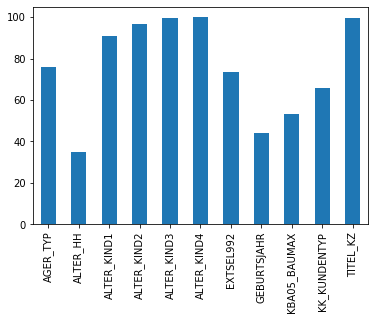

In [86]:
azdias_missing_cols_df[azdias_missing_cols_df.percentage > 30].percentage.plot(kind='bar');
plt.show()

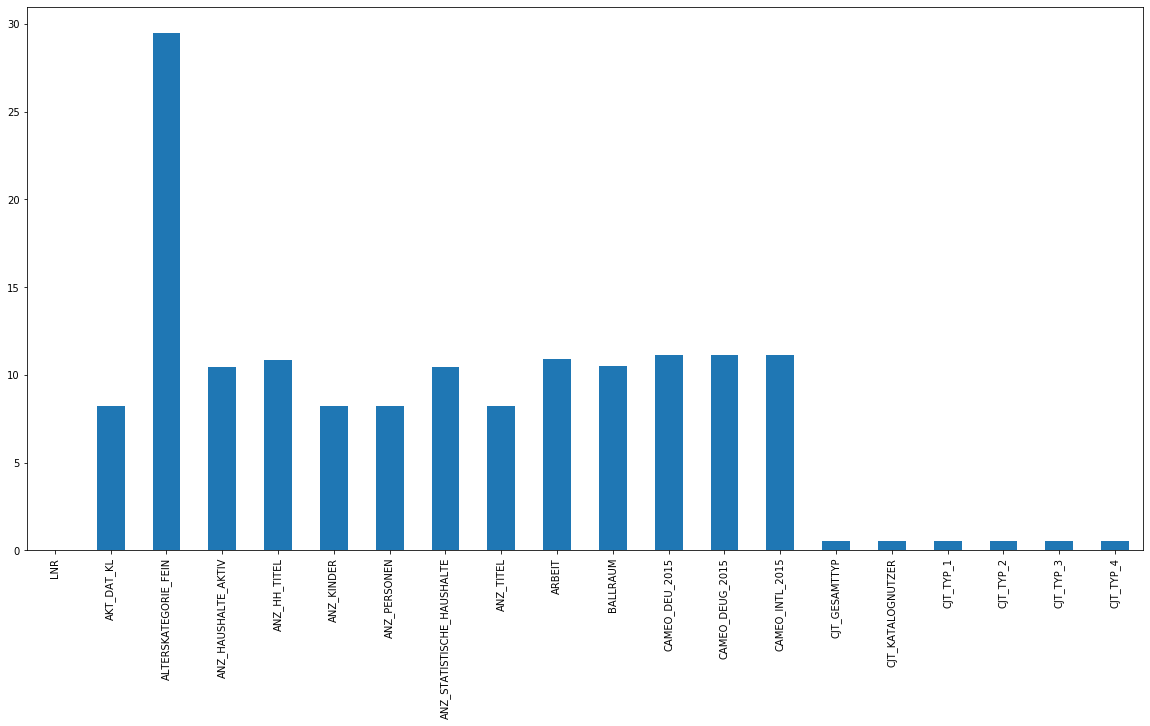

In [87]:
azdias_missing_cols_df[azdias_missing_cols_df.percentage < 30].percentage[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

Simmilar with CUSTOOMERS dataframe.

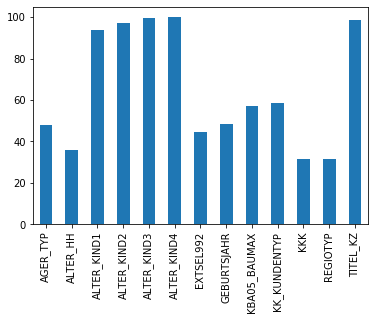

In [88]:
customers_missing_cols_df[customers_missing_cols_df.percentage > 30].percentage.plot(kind='bar');
plt.show()

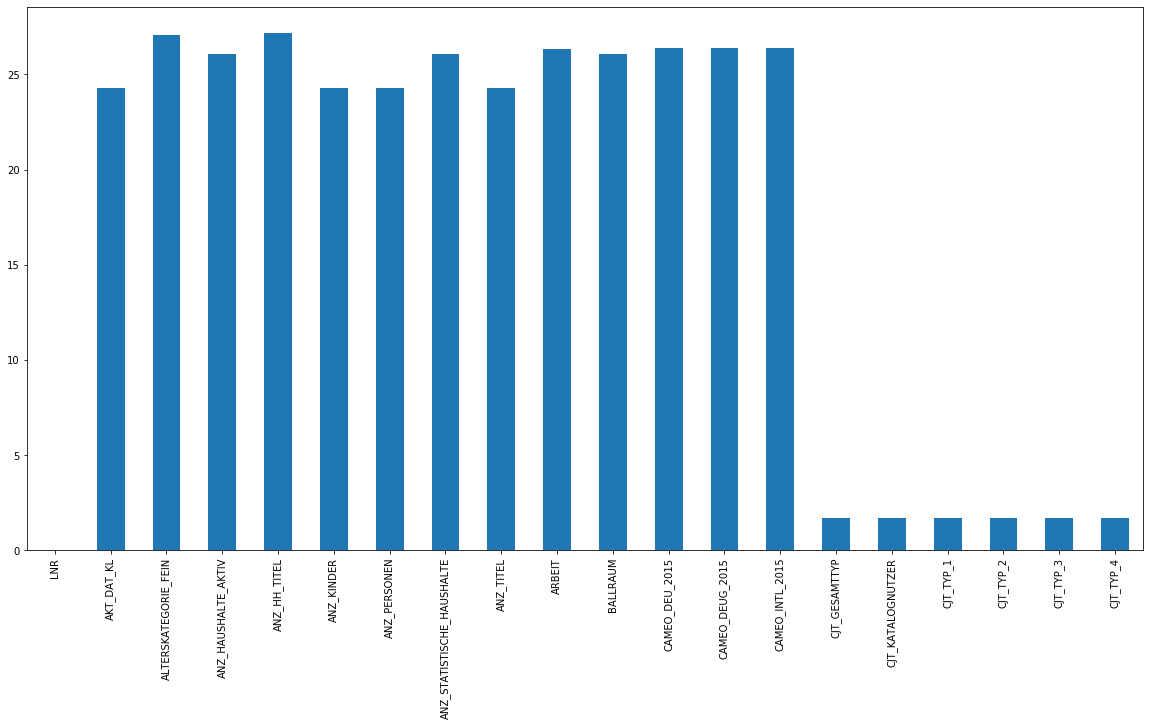

In [89]:
customers_missing_cols_df[customers_missing_cols_df.percentage < 30].percentage[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

Now I want to compare the missing by columns data from AZDIAS with CUSTOMERS. Therefore, I will merge them by column name.

In [90]:
merged = azdias_missing_cols_df.reset_index()
merged.rename(columns={'percentage':'azdias_%'}, inplace=True)
del merged["num"]
merged

,index,azdias_%
0,LNR,0.00
1,AGER_TYP,76.02
2,AKT_DAT_KL,8.25
3,ALTER_HH,34.81
4,ALTER_KIND1,90.90
...,...,...
361,WOHNDAUER_2008,8.25
362,WOHNLAGE,10.45
363,ZABEOTYP,0.00
364,ANREDE_KZ,0.00


In [91]:
temp_cus = customers_missing_cols_df.reset_index()
temp_cus.rename(columns={'percentage':'customers_%'}, inplace=True)
del temp_cus["num"]
temp_cus


,index,customers_%
0,LNR,0.00
1,AGER_TYP,48.06
2,AKT_DAT_KL,24.31
3,ALTER_HH,35.87
4,ALTER_KIND1,93.86
...,...,...
364,PRODUCT_GROUP,0.00
365,CUSTOMER_GROUP,0.00
366,ONLINE_PURCHASE,0.00
367,ANREDE_KZ,0.00


In [92]:
merged = merged.merge(temp_cus, on='index')
merged

,index,azdias_%,customers_%
0,LNR,0.00,0.00
1,AGER_TYP,76.02,48.06
2,AKT_DAT_KL,8.25,24.31
3,ALTER_HH,34.81,35.87
4,ALTER_KIND1,90.90,93.86
...,...,...,...
361,WOHNDAUER_2008,8.25,24.31
362,WOHNLAGE,10.45,26.05
363,ZABEOTYP,0.00,0.00
364,ANREDE_KZ,0.00,0.00


After I have substratedd all the required data and merged it, I would like to represent it in the form of bar-plot for better understanding.

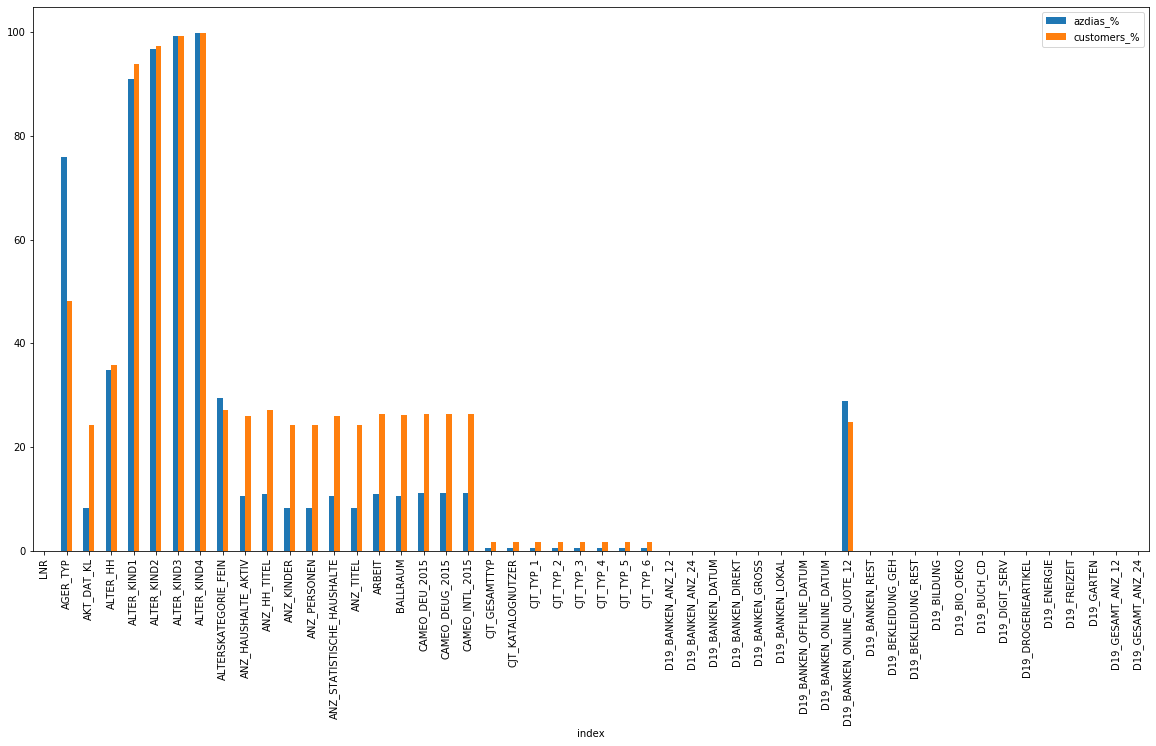

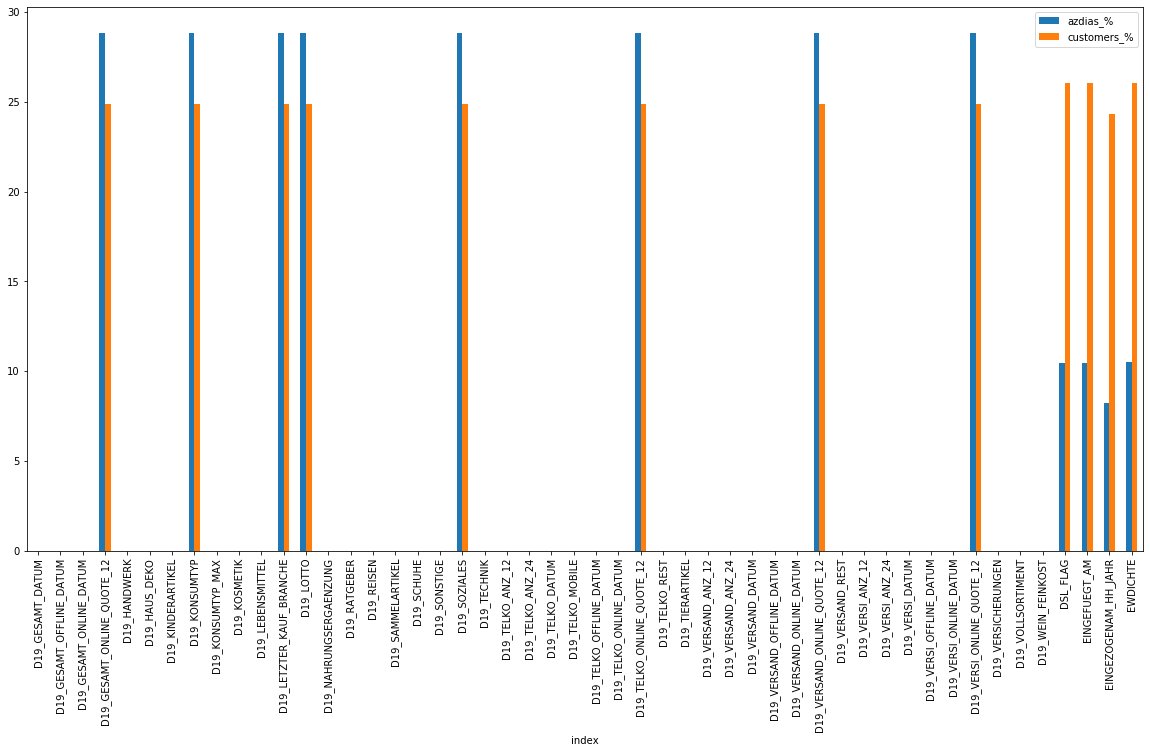

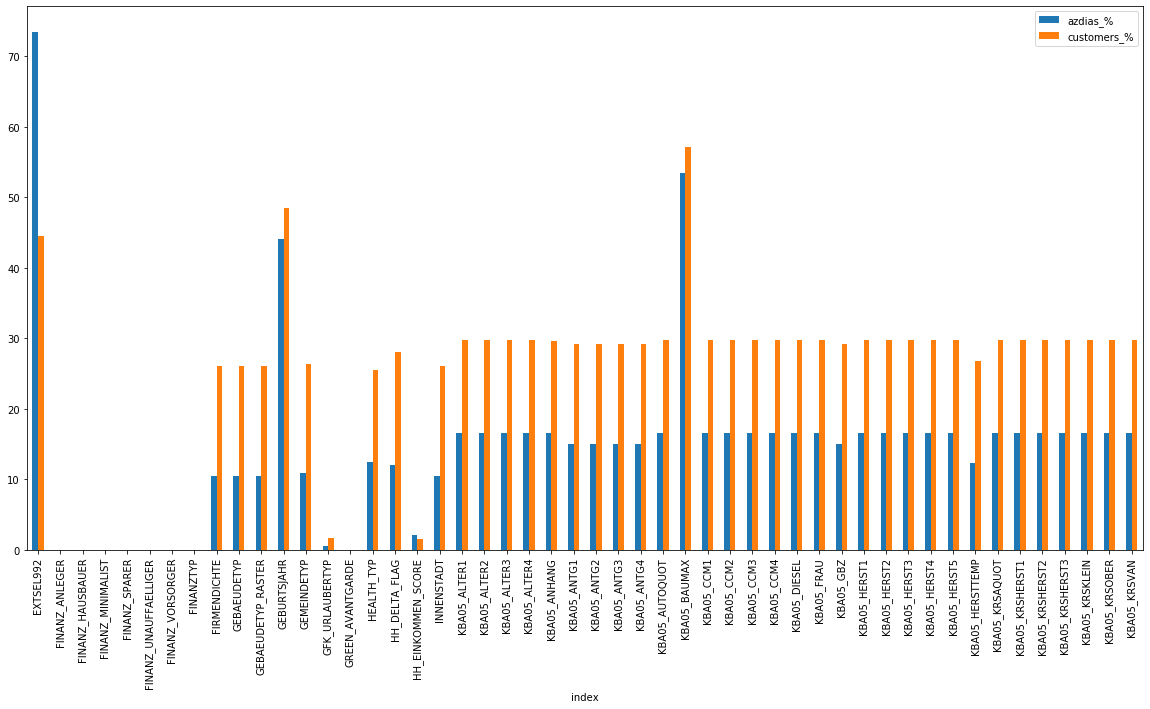

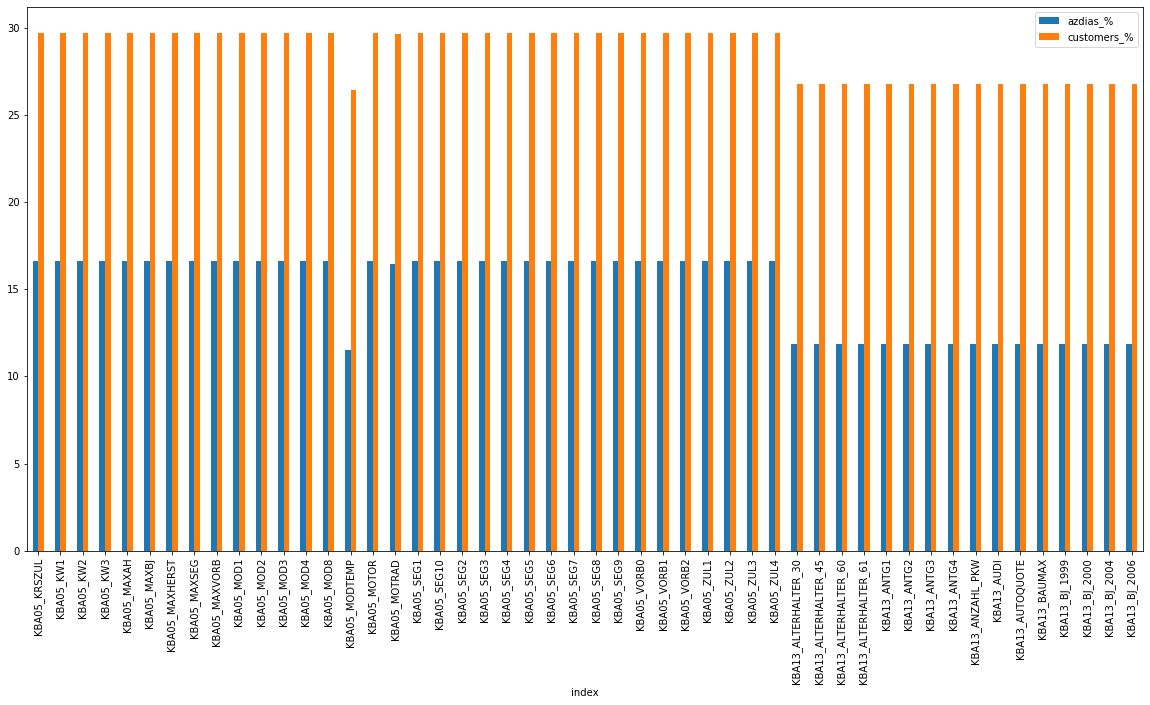

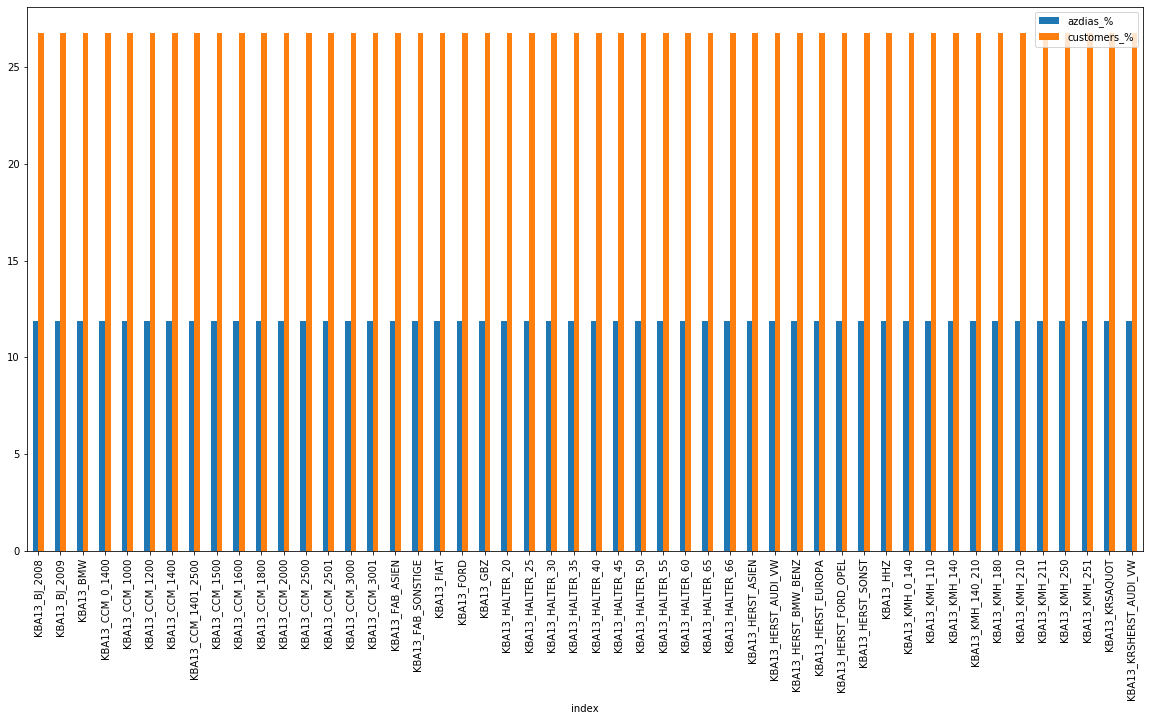

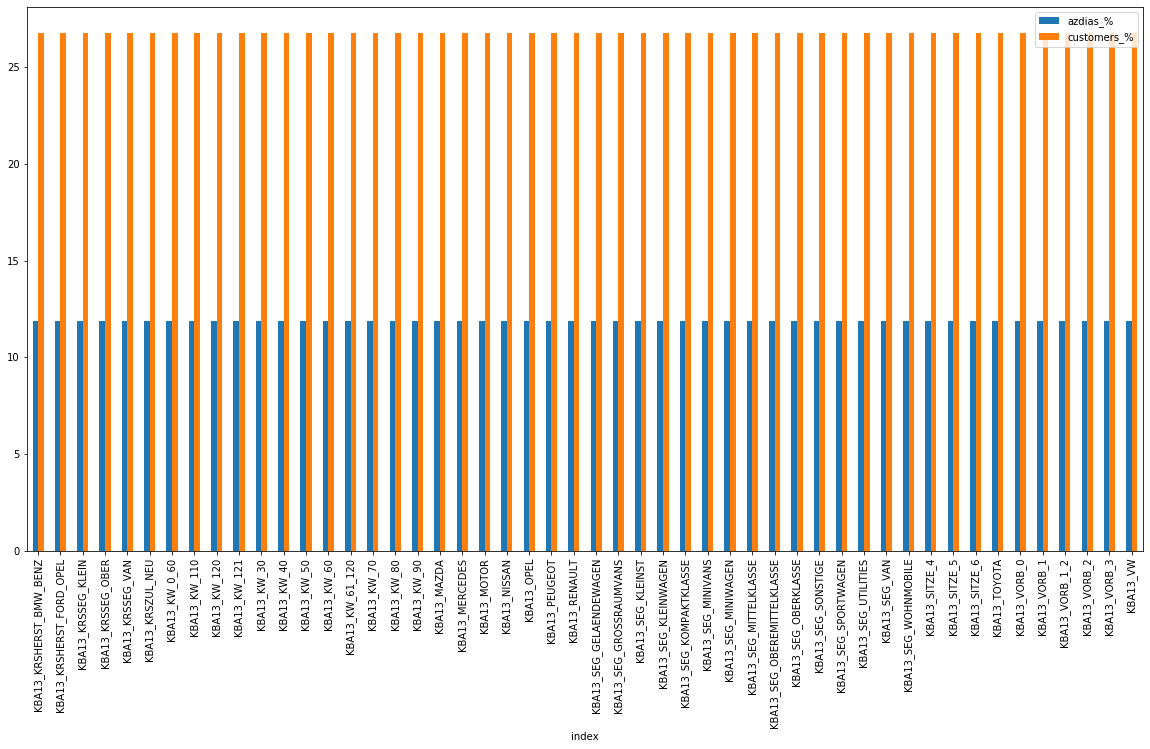

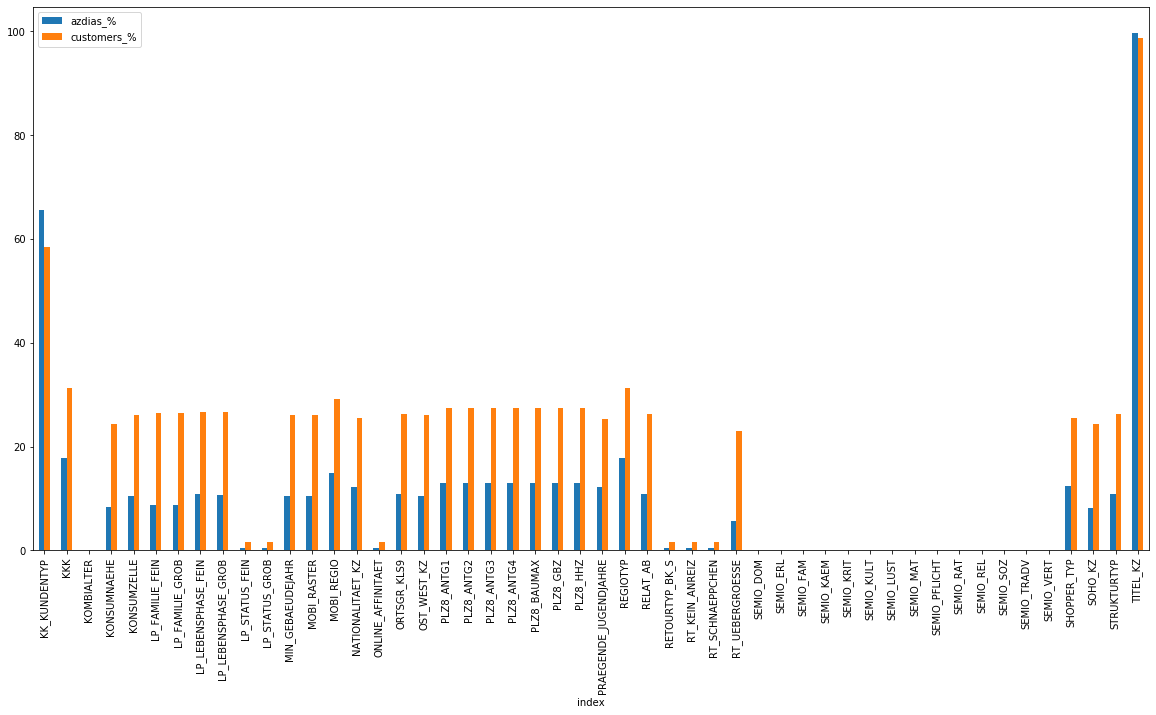

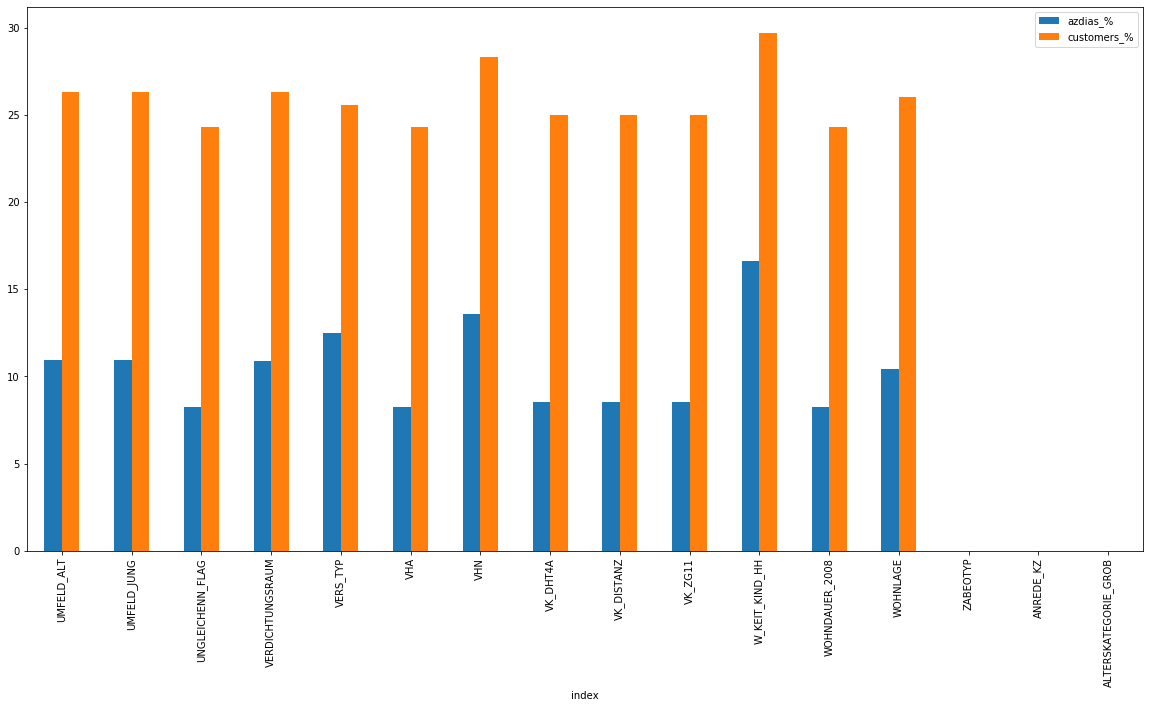

In [93]:
for i in range(0, len(merged), 50):
    
    merged[i:i+50].plot(x ='index', figsize=(20,10), kind = 'bar')

Based on the abovedepicted graph, I have made a decision to drop completely such columns where percentage of missing values in AZDIAS and CUSTOMERS higher than 30%. 

In [94]:
merged_unique = set(list(merged['index']))
#print(len(attribuets_desc_unique & merged_unique))

In [95]:
cols_to_drop = list(merged.loc[(merged['azdias_%'] > 30) & (merged['customers_%'] > 30)]['index'])
cols_to_drop

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [96]:
merged = None
temp_cus = None

In [97]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [98]:
print(filtered_azdias.shape)
print(filtered_customers.shape)

(891221, 355)
(191652, 358)


In [99]:
cols_to_drop = list((set(filtered_azdias.columns) & set(filtered_customers.columns)).difference(attribuets_desc_unique))

In [100]:
cols_to_drop

['VK_DISTANZ',
 'D19_BANKEN_REST',
 'KBA13_ANTG4',
 'CJT_TYP_5',
 'AKT_DAT_KL',
 'D19_SOZIALES',
 'D19_BANKEN_ANZ_12',
 'KONSUMZELLE',
 'RT_UEBERGROESSE',
 'ALTERSKATEGORIE_FEIN',
 'D19_TELKO_REST',
 'D19_KINDERARTIKEL',
 'UMFELD_JUNG',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'D19_BIO_OEKO',
 'CJT_TYP_2',
 'D19_BILDUNG',
 'KBA13_ANTG2',
 'VK_ZG11',
 'D19_VERSI_ANZ_24',
 'D19_SCHUHE',
 'HH_DELTA_FLAG',
 'D19_BANKEN_GROSS',
 'SOHO_KZ',
 'D19_VERSICHERUNGEN',
 'D19_BUCH_CD',
 'D19_LETZTER_KAUF_BRANCHE',
 'LNR',
 'CAMEO_INTL_2015',
 'KBA13_CCM_1401_2500',
 'CJT_TYP_6',
 'D19_TIERARTIKEL',
 'D19_REISEN',
 'D19_NAHRUNGSERGAENZUNG',
 'FIRMENDICHTE',
 'UMFELD_ALT',
 'D19_ENERGIE',
 'MOBI_RASTER',
 'D19_TELKO_MOBILE',
 'RT_KEIN_ANREIZ',
 'D19_HAUS_DEKO',
 'GEMEINDETYP',
 'D19_LEBENSMITTEL',
 'D19_TELKO_ONLINE_QUOTE_12',
 'VK_DHT4A',
 'VHN',
 'KBA13_HHZ',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_ANZ_24',
 'D19_VERSAND_REST',
 'D19_WEIN_FEINKOST',
 'D19_BANKEN_LOKAL',
 'EINGEFUEGT_AM',
 'KBA13_ANTG3',
 'KBA13_

In [101]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [102]:
print('Post-filtered Azdias df, no of left NaN values: ', filtered_azdias.isna().sum().sum())
print('Post-filtered Customers df, no of left NaN values: ', filtered_customers.isna().sum().sum())

Post-filtered Azdias df, no of left NaN values:  25537128
Post-filtered Customers df, no of left NaN values:  11213580


Now, I want to check once again the percentage of missing data and what has changed.

In [103]:
azdias_missing_cols_df, azdias_missing_rows_df = calculate_missing_data(filtered_azdias)

Missind data COLUMNs wise: 
                         num  percentage
ANZ_HAUSHALTE_AKTIV   93148       10.45
ANZ_HH_TITEL          97008       10.88
ANZ_PERSONEN          73499        8.25
ANZ_TITEL             73499        8.25
ARBEIT                97216       10.91
...                     ...         ...
WOHNDAUER_2008        73499        8.25
WOHNLAGE              93148       10.45
ZABEOTYP                  0        0.00
ANREDE_KZ                 0        0.00
ALTERSKATEGORIE_GROB      0        0.00

[259 rows x 2 columns] (259, 2)
Missind data ROWSs wise: 
         num  percentage
0       208       80.31
11      212       81.85
14      212       81.85
17      212       81.85
24      212       81.85
...     ...         ...
891164  208       80.31
891171  200       77.22
891175  212       81.85
891185  212       81.85
891187  212       81.85

[93494 rows x 2 columns] (93494, 2)


In [104]:
customers_missing_cols_df, customers_missing_rows_df = calculate_missing_data(filtered_customers)

Missind data COLUMNs wise: 
                         num  percentage
ANZ_HAUSHALTE_AKTIV   49927       26.05
ANZ_HH_TITEL          52110       27.19
ANZ_PERSONEN          46596       24.31
ANZ_TITEL             46596       24.31
ARBEIT                50476       26.34
...                     ...         ...
PRODUCT_GROUP             0        0.00
CUSTOMER_GROUP            0        0.00
ONLINE_PURCHASE           0        0.00
ANREDE_KZ                 0        0.00
ALTERSKATEGORIE_GROB      0        0.00

[262 rows x 2 columns] (262, 2)
Missind data ROWSs wise: 
         num  percentage
1       207       79.01
10      196       74.81
36      212       80.92
37      212       80.92
38      212       80.92
...     ...         ...
191467  212       80.92
191477  208       79.39
191481  212       80.92
191553  197       75.19
191565  195       74.43

[49959 rows x 2 columns] (49959, 2)


So, dealing with missing data by columns also decreased the quantity of missing data in rows. For example, for customers the quantity of rows where percentage of missing data was more than 50 decreased from 50786 to 49959, for azdias fom 99969 to 93494. Nevertheless, I would like to drop such rows where % of missing data is higher than 50. 

In [105]:
def drop_rows(df, missing_rows):
    '''This function deletes rows which are mentioned in the dataframe. 
    Args: 
    df: demographic dataframe
    missing_rows: dataframe which contained information on rows that should be removed 
    returns: updated dataframe
    '''
    
    return df[~df.index.isin(missing_rows.index)]

In [106]:
filtered_azdias = drop_rows(filtered_azdias, azdias_missing_rows_df)
filtered_customers = drop_rows(filtered_customers, customers_missing_rows_df)

### 0.6 Feature engineering and Imputation
Now, it is time to deal with the overcategorised data and missing values. I have chosen a strategy to split:
* `CAMEO_INTL_2015` into `CAMEO_INTL_2015_wealth_type` and `CAMEO_INTL_2015_family_type`
* `LP_LEBENSPHASE_FEIN` into `LP_LEBENSPHASE_FEIN_family_type`, `LP_LEBENSPHASE_FEIN_earner_type`, `LP_LEBENSPHASE_FEIN_age_group`
* `PRAEGENDE_JUGENDJAHRE` by movent type (avangard or mainstream) and decade

Afterwards, I will perform label encoding, so that string values are represented as numbers for models.
And finally, I will impute missing values with most frequent values within the columns.

In [207]:
def feature_eng(df):
    '''This function deals designated columns and imputes missing data. 
    Args: 
    df: demographic dataframe
    returns: none
    '''
    
    labelencoder = LabelEncoder()

    
    df['ANZ_HAUSHALTE_AKTIV'].fillna(df['ANZ_HAUSHALTE_AKTIV'].mean(), inplace=True)
    print('Replaced ANZ_HAUSHALTE_AKTIV')
    df['KBA13_ANZAHL_PKW'].fillna(df['KBA13_ANZAHL_PKW'].mean(), inplace=True)
    print('Replaced KBA13_ANZAHL_PKW')
    
    #CAMEO_INTL_2015
    cameo_wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 
        21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',
        31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',
        41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',
        51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    cameo_family_type = {
        11:'Pre-Family Couples & Singles',
        12:'Young Couples With Children',
        13:'Families With School Age Children',
        14:'Older Families &  Mature Couples',
        15:'Elders In Retirement',
        21:'Pre-Family Couples & Singles',
        22:'Young Couples With Children',
        23:'Families With School Age Children',
        24:'Older Families &  Mature Couples',
        25:'Elders In Retirement',
        31:'Pre-Family Couples & Singles',
        32:'Young Couples With Children',
        33:'Families With School Age Children',
        34:'Older Families &  Mature Couples',
        35:'Elders In Retirement',
        41:'Pre-Family Couples & Singles',
        42:'Young Couples With Children',
        43:'Families With School Age Children',
        44:'Older Families &  Mature Couples',
        45:'Elders In Retirement',
        51:'Pre-Family Couples & Singles',
        52:'Young Couples With Children',
        53:'Families With School Age Children',
        54:'Older Families &  Mature Couples',
        55:'Elders In Retirement',

    }
    
    #not in customers, but in azdias
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = df['CAMEO_INTL_2015'].map(cameo_wealth_type)
        df['CAMEO_INTL_2015_family_type'] = df['CAMEO_INTL_2015'].map(cameo_family_type)
    
    #LP_LEBENSPHASE_FEIN
    family_type_dict = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age_group_dict = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = df['LP_LEBENSPHASE_FEIN'].map(family_type_dict)
        df['LP_LEBENSPHASE_FEIN_earner_type'] = df['LP_LEBENSPHASE_FEIN'].map(earner_type_dict)
        df['LP_LEBENSPHASE_FEIN_age_group'] = df['LP_LEBENSPHASE_FEIN'].map(age_group_dict)
    
    #LP_FAMILIE_GROB
    family_type_dict = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = df['LP_FAMILIE_GROB'].map(family_type_dict)
    
    #LP_STATUS_GROB
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = df['LP_STATUS_GROB'].map(earner_type_dict)
    
    #PRAEGENDE_JUGENDJAHRE
    movement_dict = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    print('created PRAEGENDE_JUGENDJAHRE_movement')
    decade_dict = {
        1: '40s', 2: '40s', 3: '50s', 4: '50s',
        5: '60s', 6: '60s', 7: '60s', 8: '70s', 9: '70s', 
        10: '80s', 11: '80s', 12: '80s', 13: '80s', 14: '90s',
        15: '90s'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    print('created PRAEGENDE_JUGENDJAHRE_decade')
    
    #not in customers, but in azdias
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    list_of_obj_cols = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth_type','CAMEO_INTL_2015_family_type',
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN_family_type', 'LP_LEBENSPHASE_FEIN_earner_type', 
                        'LP_LEBENSPHASE_FEIN_age_group', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family_type', 
                        'LP_STATUS_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE', 
                        'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                        'CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                        'D19_LETZTER_KAUF_BRANCHE']
    #imputing with most frequent
    for col in df.columns:
        if col in list_of_obj_cols:
            df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
        else: 
            print(col)
            df[col].fillna(df[col].median(), inplace=True)
        #df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
        print(f'Imputed {col}')
    
    #label encoding
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_wealth_type'])
        df['CAMEO_INTL_2015_family_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_family_type'])
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_family_type'])
        df['LP_LEBENSPHASE_FEIN_earner_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_earner_type'])
        df['LP_LEBENSPHASE_FEIN_age_group'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_age_group'])

    print('Cretaed LP_LEBENSPHASE_FEIN_family_type, LP_LEBENSPHASE_FEIN_earner_type and LP_LEBENSPHASE_FEIN_age_group')
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = labelencoder.fit_transform(df['LP_FAMILIE_GROB_family_type'])

    print('Transformed LP_FAMILIE_GROB_family_type')
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = labelencoder.fit_transform(df['LP_STATUS_GROB_earner_type'])

    print('Transformed LP_STATUS_GROB_earner_type')
    drop_cols = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore')
    
    #OST_WEST_KZ
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = labelencoder.fit_transform(df['OST_WEST_KZ'])
        print('Transformed OST_WEST_KZ')
    
    #CAMEO_DEU_2015
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = labelencoder.fit_transform(df['CAMEO_DEU_2015'])
        print('Transformed CAMEO_DEU_2015')
    
    
    for value in ['PRODUCT_GROUP', 'CUSTOMER_GROUP']:
        if value in df.columns:
            df[value] = labelencoder.fit_transform(df[value])
            print(f'Transformed {value}')
            
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])

In [108]:
feature_eng(filtered_azdias)
feature_eng(filtered_customers)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
Imputed D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
Imputed D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
Imputed D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_DATUM
Imputed D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
Imputed D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
Imputed D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
Imputed D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
Imputed D19_KONSUMTYP
D19_TELKO_DATUM
Imputed D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
Imputed D19_TELKO_OFFLINE_DATUM
D19_TELKO_

Imputed LP_FAMILIE_GROB
Imputed LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
Imputed LP_LEBENSPHASE_GROB
LP_STATUS_FEIN
Imputed LP_STATUS_FEIN
Imputed LP_STATUS_GROB
MIN_GEBAEUDEJAHR
Imputed MIN_GEBAEUDEJAHR
MOBI_REGIO
Imputed MOBI_REGIO
NATIONALITAET_KZ
Imputed NATIONALITAET_KZ
ONLINE_AFFINITAET
Imputed ONLINE_AFFINITAET
ORTSGR_KLS9
Imputed ORTSGR_KLS9
Imputed OST_WEST_KZ
PLZ8_ANTG1
Imputed PLZ8_ANTG1
PLZ8_ANTG2
Imputed PLZ8_ANTG2
PLZ8_ANTG3
Imputed PLZ8_ANTG3
PLZ8_ANTG4
Imputed PLZ8_ANTG4
PLZ8_BAUMAX
Imputed PLZ8_BAUMAX
PLZ8_GBZ
Imputed PLZ8_GBZ
PLZ8_HHZ
Imputed PLZ8_HHZ
Imputed PRAEGENDE_JUGENDJAHRE
REGIOTYP
Imputed REGIOTYP
RELAT_AB
Imputed RELAT_AB
RETOURTYP_BK_S
Imputed RETOURTYP_BK_S
SEMIO_DOM
Imputed SEMIO_DOM
SEMIO_ERL
Imputed SEMIO_ERL
SEMIO_FAM
Imputed SEMIO_FAM
SEMIO_KAEM
Imputed SEMIO_KAEM
SEMIO_KRIT
Imputed SEMIO_KRIT
SEMIO_KULT
Imputed SEMIO_KULT
SEMIO_LUST
Imputed SEMIO_LUST
SEMIO_MAT
Imputed SEMIO_MAT
SEMIO_PFLICHT
Imputed SEMIO_PFLICHT
SEMIO_RAT
Imputed SEMIO_RAT
SEMIO_REL

Imputed KBA13_KW_70
KBA13_KW_80
Imputed KBA13_KW_80
KBA13_KW_90
Imputed KBA13_KW_90
KBA13_MAZDA
Imputed KBA13_MAZDA
KBA13_MERCEDES
Imputed KBA13_MERCEDES
KBA13_MOTOR
Imputed KBA13_MOTOR
KBA13_NISSAN
Imputed KBA13_NISSAN
KBA13_OPEL
Imputed KBA13_OPEL
KBA13_PEUGEOT
Imputed KBA13_PEUGEOT
KBA13_RENAULT
Imputed KBA13_RENAULT
KBA13_SEG_GELAENDEWAGEN
Imputed KBA13_SEG_GELAENDEWAGEN
KBA13_SEG_GROSSRAUMVANS
Imputed KBA13_SEG_GROSSRAUMVANS
KBA13_SEG_KLEINST
Imputed KBA13_SEG_KLEINST
KBA13_SEG_KLEINWAGEN
Imputed KBA13_SEG_KLEINWAGEN
KBA13_SEG_KOMPAKTKLASSE
Imputed KBA13_SEG_KOMPAKTKLASSE
KBA13_SEG_MINIVANS
Imputed KBA13_SEG_MINIVANS
KBA13_SEG_MINIWAGEN
Imputed KBA13_SEG_MINIWAGEN
KBA13_SEG_MITTELKLASSE
Imputed KBA13_SEG_MITTELKLASSE
KBA13_SEG_OBEREMITTELKLASSE
Imputed KBA13_SEG_OBEREMITTELKLASSE
KBA13_SEG_OBERKLASSE
Imputed KBA13_SEG_OBERKLASSE
KBA13_SEG_SONSTIGE
Imputed KBA13_SEG_SONSTIGE
KBA13_SEG_SPORTWAGEN
Imputed KBA13_SEG_SPORTWAGEN
KBA13_SEG_UTILITIES
Imputed KBA13_SEG_UTILITIES
KBA13_SEG_

Now, I want to use feature correlation across the entire dataset to determine which features are too highly-correlated. Because if such exist they may over-inflate the importance of a single feature.

In [109]:
def corr_to_drop(df):
    
    # Create correlation matrix for just Features to determine different models to test
    corr_matrix = df.corr().abs().round(2)

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find features with correlation greater than 0.90
    cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    
    return cols_to_drop

So, belove-mentioned columns whith threshold >0.90 will be removed.

In [110]:
cols_to_drop = corr_to_drop(filtered_azdias)
print(cols_to_drop)

['CAMEO_DEUG_2015', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE_movement']


In [111]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

At this moment, I want to have a quick view on the distribution of the data across all collumns.

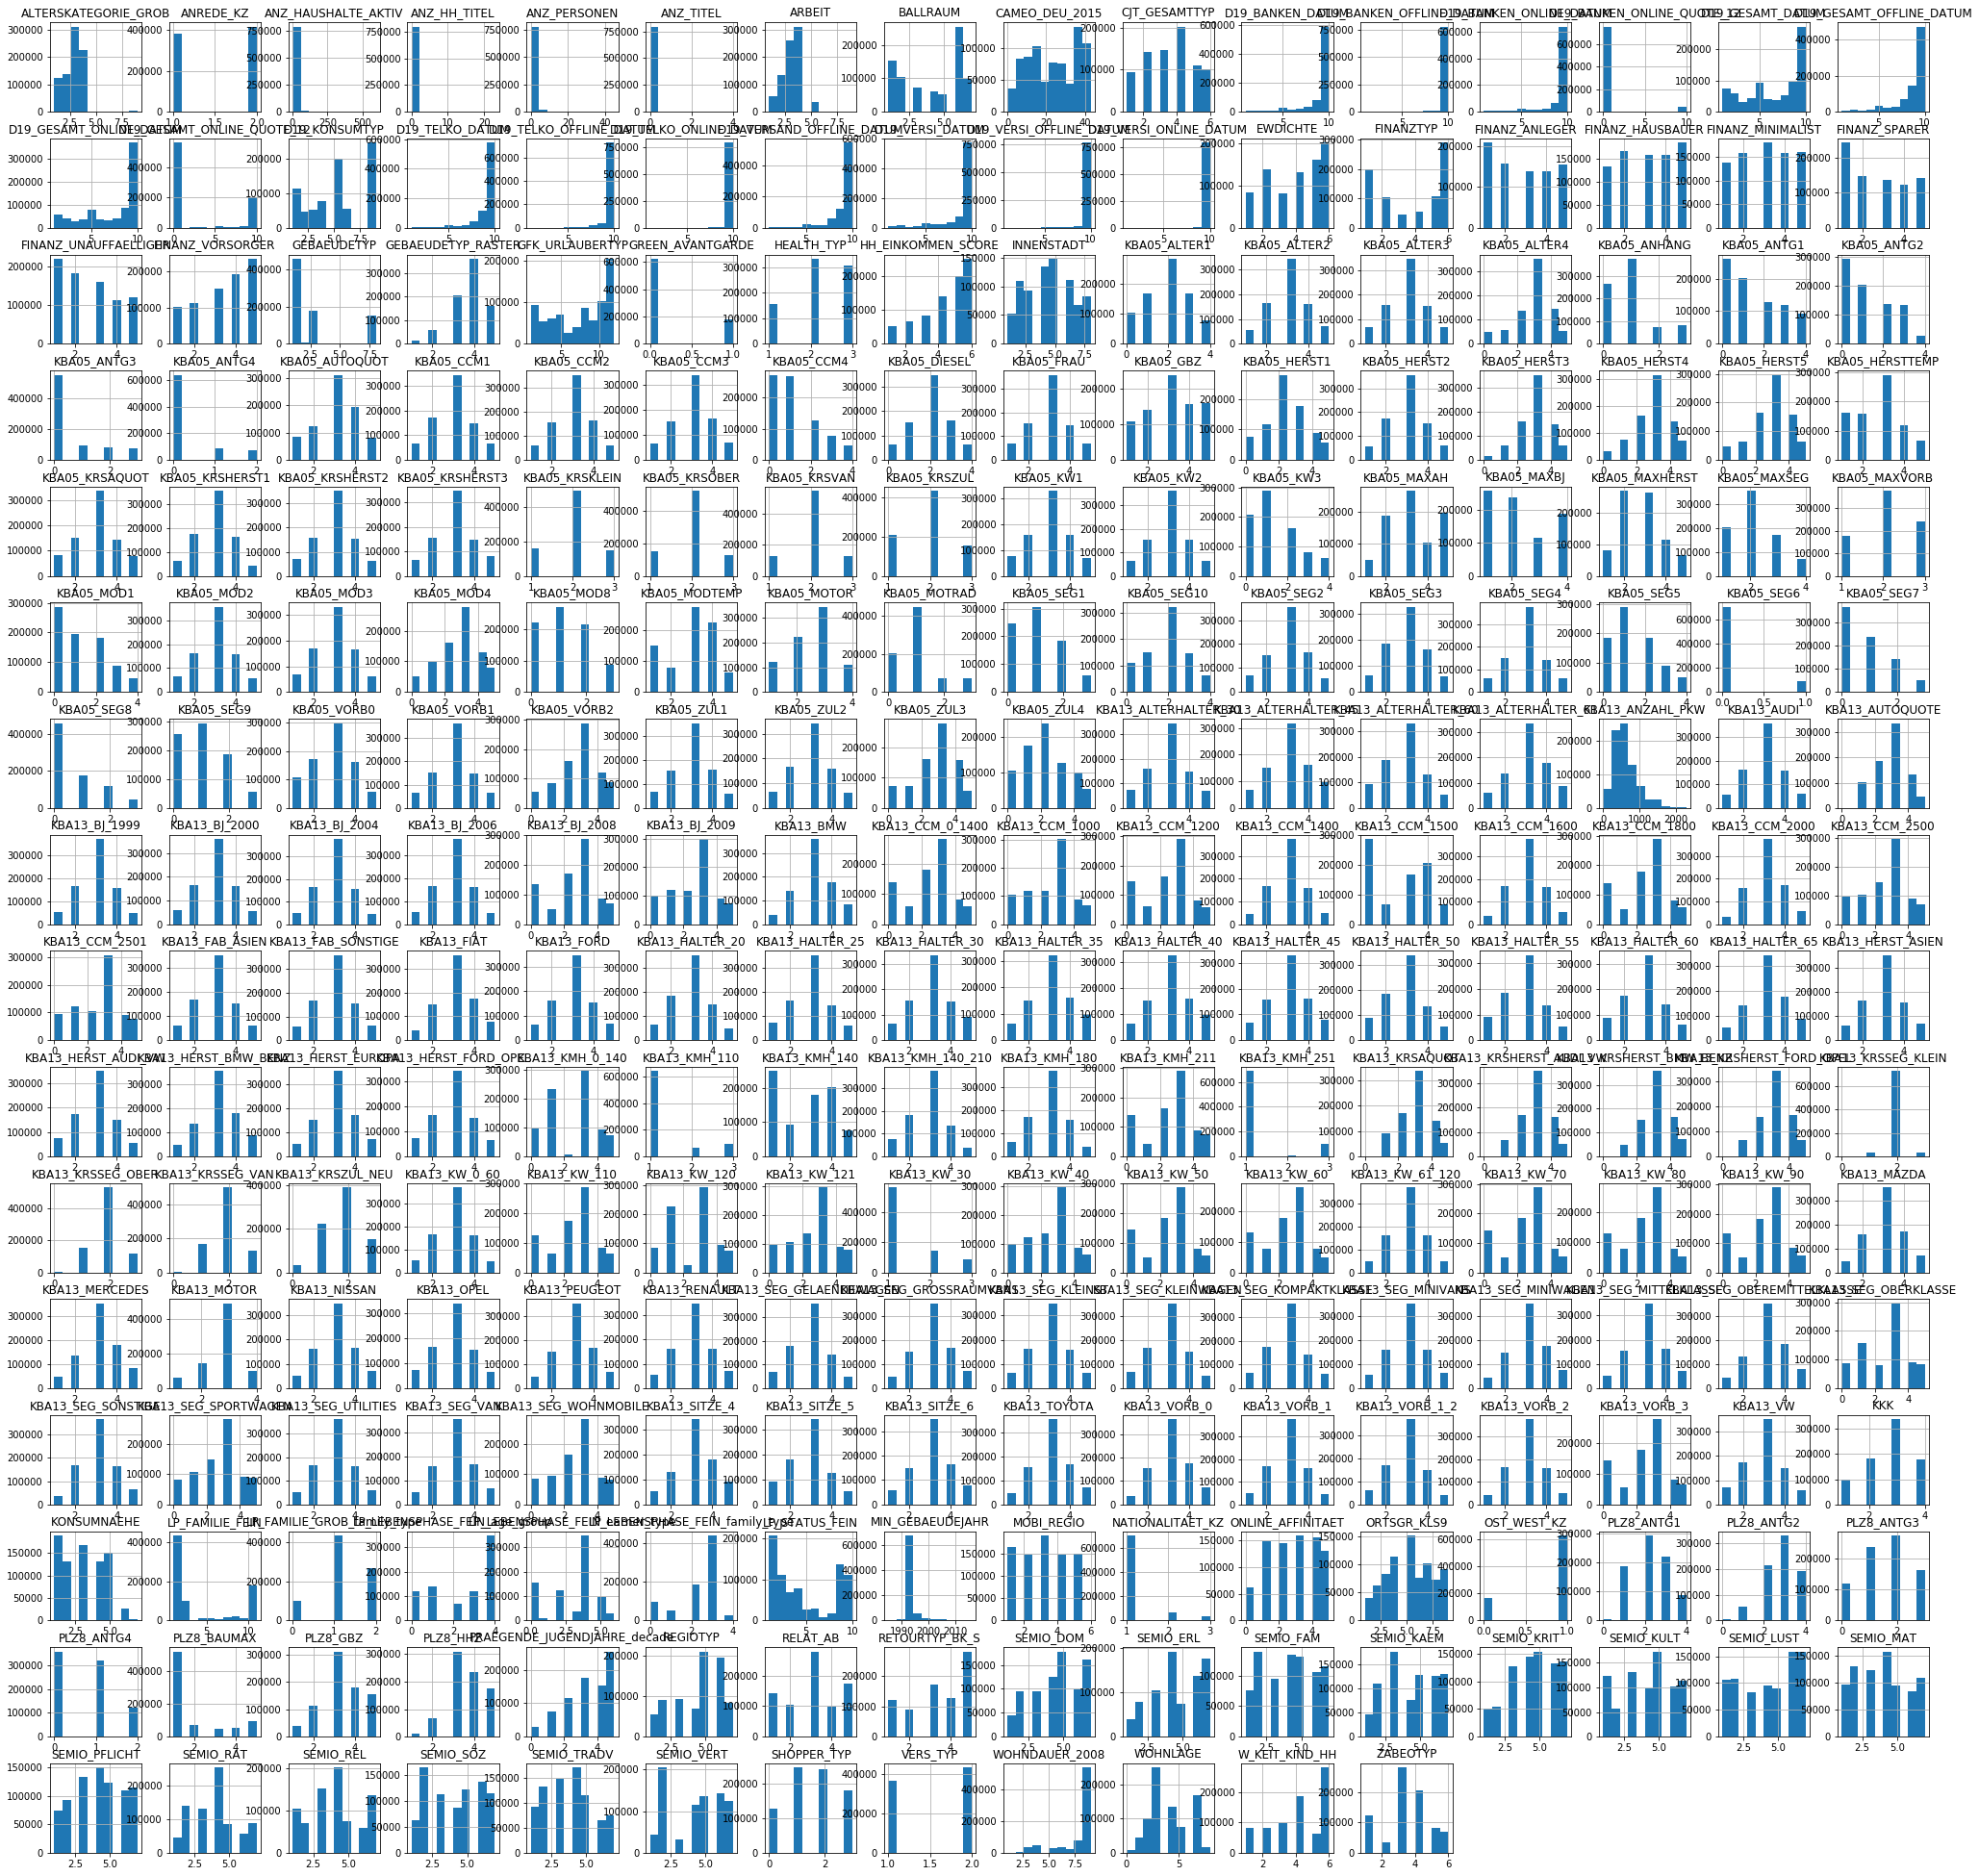

In [112]:
filtered_azdias.hist(figsize = (35,35))
plt.show()

In [113]:
def perform_log_transform(df):
    df_log = pd.DataFrame()

    for col in df.columns:
        df_log[col]=(df[col]+1).transform(np.log)
    return df_log

In [114]:
azdias_log = perform_log_transform(filtered_azdias)
customers_log = perform_log_transform(filtered_customers)


In [115]:
azdias_log.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,PRAEGENDE_JUGENDJAHRE_decade
1,2.484907,0.0,1.098612,0.0,1.386294,1.945910,3.583519,1.791759,2.397895,2.397895,...,2.302585,1.609438,1.791759,1.098612,0.693147,1.609438,1.609438,1.609438,1.098612,1.791759
2,2.397895,0.0,0.693147,0.0,1.386294,1.098612,2.772589,1.386294,2.397895,2.397895,...,2.302585,1.098612,1.791759,1.098612,1.386294,1.386294,0.000000,1.609438,0.693147,1.791759
3,0.693147,0.0,0.000000,0.0,1.098612,1.609438,1.791759,1.098612,2.397895,2.397895,...,2.302585,2.079442,1.386294,1.098612,1.609438,1.386294,1.609438,1.609438,0.693147,1.386294
4,1.386294,0.0,1.609438,0.0,1.609438,1.098612,3.258097,1.791759,1.791759,2.397895,...,2.302585,1.386294,1.609438,0.693147,1.386294,1.098612,0.000000,0.693147,1.098612,1.386294
5,1.791759,0.0,0.693147,0.0,1.098612,1.945910,3.637586,1.098612,2.397895,2.397895,...,2.302585,2.079442,1.609438,1.098612,0.693147,1.386294,0.000000,1.386294,0.693147,0.693147


In [116]:
filtered_azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,PRAEGENDE_JUGENDJAHRE_decade
1,11.0,0.0,2.0,0.0,3.0,6.0,35,5.0,10,10,...,9.0,4.0,5.0,2.0,1.0,4,4,4,2,5
2,10.0,0.0,1.0,0.0,3.0,2.0,15,3.0,10,10,...,9.0,2.0,5.0,2.0,3.0,3,0,4,1,5
3,1.0,0.0,0.0,0.0,2.0,4.0,5,2.0,10,10,...,9.0,7.0,3.0,2.0,4.0,3,4,4,1,3
4,3.0,0.0,4.0,0.0,4.0,2.0,25,5.0,5,10,...,9.0,3.0,4.0,1.0,3.0,2,0,1,2,3
5,5.0,0.0,1.0,0.0,2.0,6.0,37,2.0,10,10,...,9.0,7.0,4.0,2.0,1.0,3,0,3,1,1


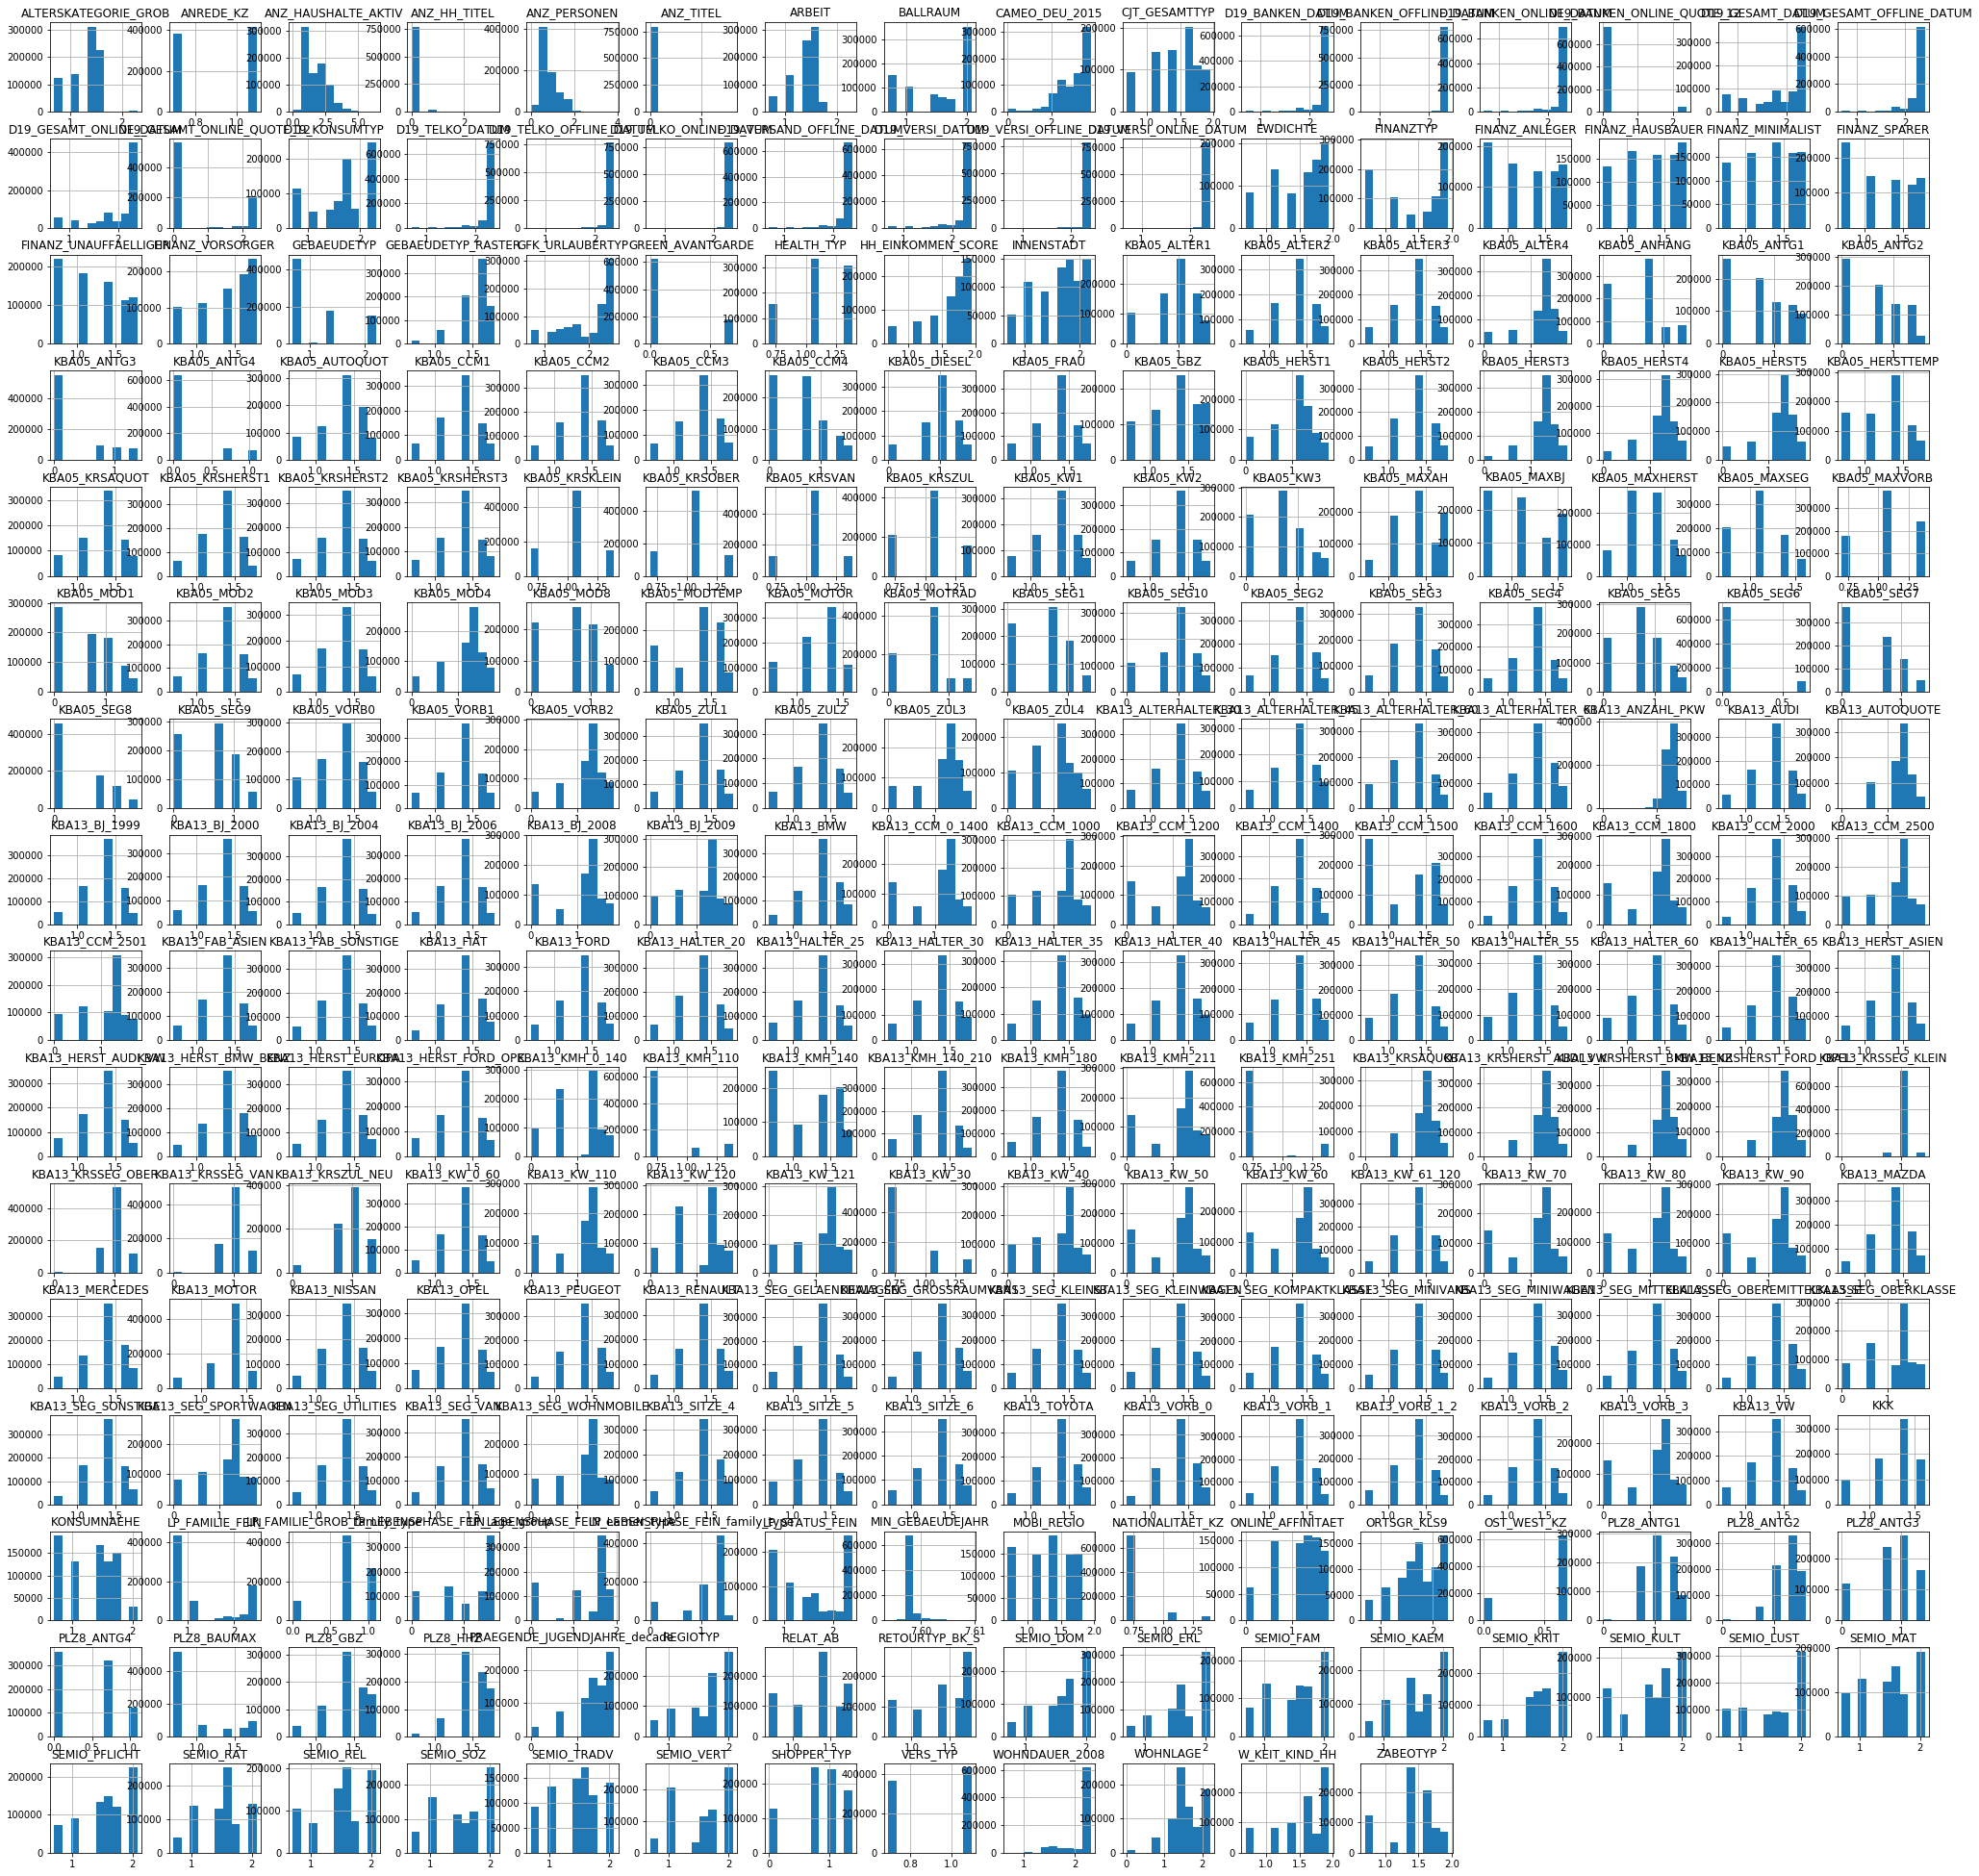

In [117]:
azdias_log.hist(figsize = (35,35))
plt.show()

### 0.7 Feature scaling

Before moving to the dimensionality reduction and clustering there is left one important step -  feature scaling.

In [118]:
def feature_scaling(df):
    
    scaled = MinMaxScaler().fit_transform(df)

    return pd.DataFrame(scaled, columns = df.columns)
    

In [119]:
filtered_azdias = feature_scaling(filtered_azdias)
filtered_customers = feature_scaling(filtered_customers)

In [120]:
azdias_log = feature_scaling(azdias_log)
customers_log = feature_scaling(customers_log)

In [121]:
filtered_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141693 entries, 0 to 141692
Columns: 255 entries, ANZ_HAUSHALTE_AKTIV to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(255)
memory usage: 275.7 MB


### Save the pre-processed data

In [78]:
filtered_azdias.to_csv('./data/Udacity_AZDIAS_clean.csv', index=False, sep=';')
filtered_customers.to_csv('./data/Udacity_CUSTOMERS_clean.csv', index=False, sep=';')

In [79]:
azdias_log.to_csv('./data/Udacity_AZDIAS_log_clean.csv', index=False, sep=';')
customers_log.to_csv('./data/Udacity_CUSTOMERS_log_clean.csv', index=False, sep=';')

filtered_azdias = None
filtered_customers = None
azdias_log = None
customers_log = None

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

filtered_azdias = pd.read_csv('./data/Udacity_AZDIAS_clean.csv', sep=';')
filtered_customers = pd.read_csv('./data/Udacity_CUSTOMERS_clean.csv', sep=';')

azdias_log = pd.read_csv('./data/Udacity_AZDIAS_log_clean.csv', sep=';')
customers_log = pd.read_csv('./data/Udacity_CUSTOMERS_log_clean.csv', sep=';')

In [80]:
attribuets_desc = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1)
attributes_values =  pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,ZABEOTYP,typification of energy consumers,2,smart
2254,NaN,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,NaN,ZABEOTYP,typification of energy consumers,4,price driven
2256,NaN,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [81]:
print(len(azdias_log.columns.values))
customers_log.info()

252
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141693 entries, 0 to 141692
Columns: 255 entries, ANZ_HAUSHALTE_AKTIV to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(255)
memory usage: 275.7 MB


In [82]:
attribuets_desc.drop(columns=['Unnamed: 0'], inplace=True)

### 1.1 PCA

In [122]:
def sklearn_pca(data, n_components=None):
    '''This function builds the scikit-learn PCA model. 
    Args: 
    data: demographic dataframe
    n_components: number of components
    returns: 
    pca: pca model
    data_transformed: transformed data
    '''
    pca = PCA(n_components)
    data_transformed = pca.fit_transform(data)
    return pca, data_transformed

In [123]:
def plot_variance_sklearn(pca):
    '''This function plots the graph of the explained variance ratio. 
    Args: 
    pca: pca model
    returns: none
    '''
    exp_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(exp_variance)
    plt.xlabel('No of Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(b=True)
    plot = plt.show()

In [124]:
azdias_pca_model, pca_transformed = sklearn_pca(filtered_azdias)

In [86]:
def plot_elbow_curve(data):
    '''This function performes 13 KMeans model for each
    k in range from 2 to 15, in order to find the most suitable K-value
    and plots the graph for the elbow method. 
    Args: 
    data: demographic dataframe
    returns: none
    '''
    points = np.array([])
    K = range(2,15)
    for k in K:
        
        t = time.time()
        
        kmeans = KMeans(k)
        km = kmeans.fit(data)
        points = np.append(points, np.abs(km.score(data)))
        print("Done in {:.2f} sec.".format(time.time()-t))
        
    plt.plot(K, points, 'bx-')
    plt.xlabel('no of K')
    plt.ylabel('avg distance to centroid')
    plt.title('Elbow Graph')
    plt.show()

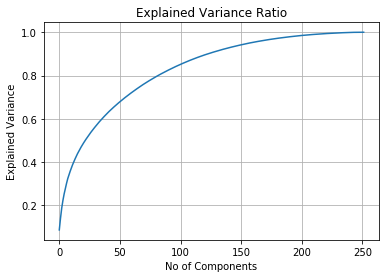

In [87]:
plot_variance_sklearn(azdias_pca_model)


From the graph I may conclude that with 125 component I can cover 90% of the data.

In [125]:
azdias_pca_model, azdias_pca_transformed_125 = sklearn_pca(filtered_azdias, 125)

### Elbow Method

Done in 6.62 sec.
Done in 15.42 sec.
Done in 20.97 sec.
Done in 29.44 sec.
Done in 35.31 sec.
Done in 36.39 sec.
Done in 35.84 sec.
Done in 48.55 sec.
Done in 49.75 sec.
Done in 72.44 sec.
Done in 58.05 sec.
Done in 67.26 sec.
Done in 64.98 sec.


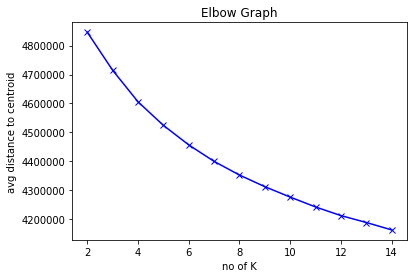

In [89]:
plot_elbow_curve(azdias_pca_transformed_125)

### KMeans

In [126]:
def sklearn_KMeans(data):
    '''This function build the final version of the scikit-learn KMeans model. 
    Args: 
    data: demographic dataframe
    returns: 
    kmeans: kmeans model
    km: kmeans transformed data
    '''
    kmeans = KMeans(9)
    km = kmeans.fit_predict(data)
    return kmeans, km

I will run PCA model for AZDIAS and CUSTOMERS for 125 clusters. After, I will run KMeans model for the given output from the PCA.

In [127]:
customers_pca_model, customers_pca_transformed_125 = sklearn_pca(filtered_customers, 125)

In [128]:
azdias_km_model, azdias_km_predict = sklearn_KMeans(azdias_pca_transformed_125)

In [129]:
customers_km_model, customers_km_predict = sklearn_KMeans(customers_pca_transformed_125)

In [130]:
print(type(azdias_km_predict))
print(type(customers_km_predict))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [131]:
azdias_km_predict = pd.Series(azdias_km_predict, name='Azdias')
customers_km_predict = pd.Series(customers_km_predict, name='Customers')

In [132]:
azdias_km_predict.value_counts().sort_index()

0     90059
1    123511
2     60565
3     59008
4     58742
5    128862
6     81661
7    100964
8     94355
Name: Azdias, dtype: int64

In [133]:
clusters_df = pd.concat([azdias_km_predict.value_counts().sort_index(), customers_km_predict.value_counts().sort_index()], axis=1)

In [134]:
clusters_df = clusters_df.assign(perc_of_Azdias=lambda x: round((x.Azdias * 100 / clusters_df.Azdias.sum()),2))
clusters_df = clusters_df.assign(perc_of_Customers=lambda x: round((x.Customers * 100 / clusters_df.Customers.sum()),2))

In [135]:
clusters_df

,Azdias,Customers,perc_of_Azdias,perc_of_Customers
0,90059,6061,11.29,4.28
1,123511,19940,15.48,14.07
2,60565,15843,7.59,11.18
3,59008,13971,7.40,9.86
4,58742,20232,7.36,14.28
5,128862,19836,16.15,14.00
6,81661,14827,10.24,10.46
7,100964,19293,12.66,13.62
8,94355,11690,11.83,8.25


I would like to compare this data in the form of the graph.

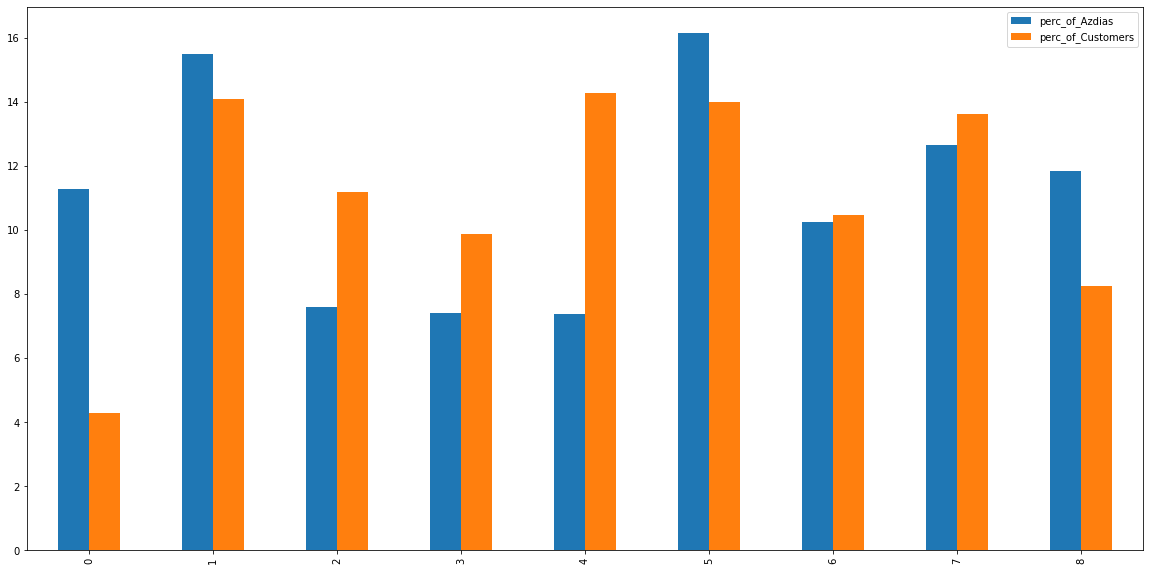

In [136]:
clusters_df[['perc_of_Azdias', 'perc_of_Customers']].plot(figsize=(20,10), kind = 'bar')

So I am interested in those clusters where Percentage of Customers is higher than Azdias. Which means that the description of potential new customers of the company falls under those clusters.

In [148]:
def combine_info(df, pca, kmeans, cluster):
    '''This function reverses the output of the KMeans and PCA, so that
    it possible to understand values from which columns describe clusters. 
    Args: 
    data: demographic dataframe
    pca: pca model
    kmeans: kmeans model
    cluster: number of the cluster (index)
    returns: none
    '''
    clusters_dict = dict(zip(df.columns, pca.inverse_transform(kmeans.cluster_centers_[cluster])))
    cluster_df = pd.DataFrame.from_dict(clusters_dict, orient='index', columns=['Values']).sort_values(by='Values')
    cluster_df['Description'] = np.nan
    for index, row in attribuets_desc.iterrows():
        index_val = row['Attribute']
        cluster_df.loc[cluster_df.index == index_val, "Description"] = row['Description']
        
    #cluster_df = pd.concat((cluster_df[:10], cluster_df[-10:]), axis=0)
    print(cluster_df[-20:])
    cluster_df[-20:].plot(kind='barh')

                             Values  \
SEMIO_DOM                  0.769067   
D19_VERSAND_OFFLINE_DATUM  0.797306   
FINANZ_MINIMALIST          0.799582   
SEMIO_KAEM                 0.802916   
LP_STATUS_FEIN             0.813549   
SEMIO_KRIT                 0.821393   
D19_VERSI_DATUM            0.898460   
FINANZ_VORSORGER           0.906563   
D19_BANKEN_DATUM           0.922983   
D19_TELKO_DATUM            0.934624   
SEMIO_ERL                  0.934847   
D19_BANKEN_ONLINE_DATUM    0.951375   
WOHNDAUER_2008             0.958998   
OST_WEST_KZ                0.970976   
D19_TELKO_OFFLINE_DATUM    0.974944   
ANREDE_KZ                  0.978575   
D19_BANKEN_OFFLINE_DATUM   0.983675   
D19_VERSI_OFFLINE_DATUM    0.989348   
D19_TELKO_ONLINE_DATUM     0.996977   
D19_VERSI_ONLINE_DATUM     0.997830   

                                                                 Description  
SEMIO_DOM                  affinity indicating in what way the person is ...  
D19_VERSAND_OFFLINE_DA

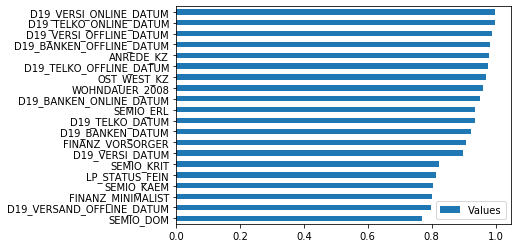

In [149]:
combine_info(filtered_customers, customers_pca_model, customers_km_model, 4)

                               Values  \
LP_FAMILIE_FEIN              0.759035   
KBA05_GBZ                    0.760936   
GREEN_AVANTGARDE             0.776283   
D19_BANKEN_DATUM             0.809382   
D19_VERSI_DATUM              0.810162   
FINANZ_VORSORGER             0.823034   
ONLINE_AFFINITAET            0.830084   
SEMIO_VERT                   0.859312   
D19_BANKEN_ONLINE_DATUM      0.867055   
D19_TELKO_DATUM              0.869787   
LP_STATUS_FEIN               0.884504   
LP_FAMILIE_GROB_family_type  0.895848   
FINANZ_MINIMALIST            0.940135   
D19_TELKO_OFFLINE_DATUM      0.947555   
D19_BANKEN_OFFLINE_DATUM     0.961530   
WOHNDAUER_2008               0.962295   
OST_WEST_KZ                  0.966255   
D19_VERSI_OFFLINE_DATUM      0.976081   
D19_TELKO_ONLINE_DATUM       0.994577   
D19_VERSI_ONLINE_DATUM       0.994869   

                                                                   Description  
LP_FAMILIE_FEIN                                          

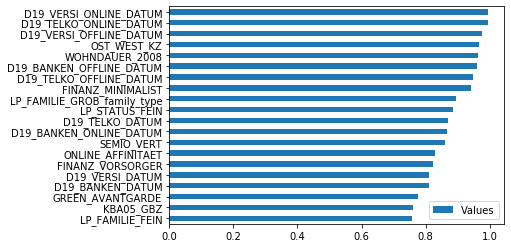

In [151]:
combine_info(filtered_customers, customers_pca_model, customers_km_model, 1)

                                Values  \
WOHNDAUER_2008                0.800020   
FINANZ_SPARER                 0.806225   
ORTSGR_KLS9                   0.810667   
CAMEO_DEU_2015                0.831411   
PLZ8_ANTG2                    0.854523   
PLZ8_ANTG3                    0.873593   
PRAEGENDE_JUGENDJAHRE_decade  0.901811   
EWDICHTE                      0.918437   
D19_BANKEN_DATUM              0.922078   
D19_GESAMT_OFFLINE_DATUM      0.930812   
D19_TELKO_DATUM               0.932990   
D19_VERSI_DATUM               0.933534   
D19_BANKEN_ONLINE_DATUM       0.939743   
HH_EINKOMMEN_SCORE            0.956265   
D19_VERSAND_OFFLINE_DATUM     0.966572   
D19_TELKO_OFFLINE_DATUM       0.984707   
D19_VERSI_OFFLINE_DATUM       0.992016   
D19_BANKEN_OFFLINE_DATUM      0.993941   
D19_VERSI_ONLINE_DATUM        0.996936   
D19_TELKO_ONLINE_DATUM        0.998609   

                                                                    Description  
WOHNDAUER_2008                     

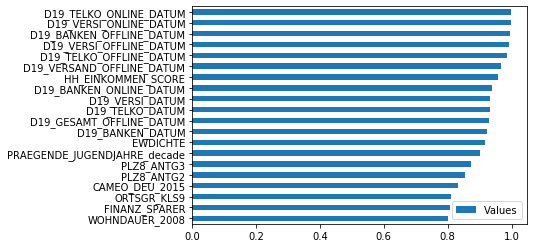

In [150]:
combine_info(filtered_azdias, azdias_pca_model, azdias_km_model, 0)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [208]:
mailout_train = None
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [209]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


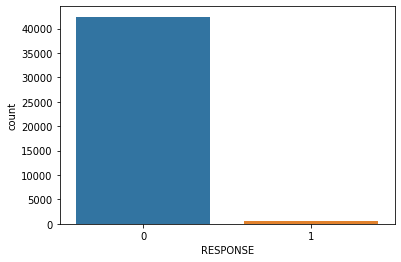

In [210]:
sns.countplot("RESPONSE", data=mailout_train)

### 2.1 Data preprocessing

In [211]:
def prepare_for_supervised_model(df, mailout_train, test=False):
    '''This function prepares the MAILOUT_TRAIN dataset 
    for training under the supervised model. This function uses
    the functionality of the above declared functions.
    Args: 
    df: demographic dataframe
    returns: preprocessed dataframe
    '''
    print('Format mixed-types \n')      
    df = format_mixed_types(df)
    
    print('Replace unknowns \n')   
    replace_unknown_with_nan(df, dict_of_unknown_names)
    additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}
    replace_unknown_with_nan(df, additional_missing_values)
    
    print('Removing outliers \n')
    remove_outliers(df, df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']])
    
    missing_cols_df, missing_rows_df = calculate_missing_data(df)
    
    print('Removing columns with missing data \n')
    cols_to_drop = missing_cols_df.index[missing_cols_df['percentage'] > 30].tolist()
    df = df.drop(cols_to_drop, axis = 1)
    
    #if not test:
    #df = drop_rows(df, missing_rows_df)
    
    print('Removing columns with overcorr data \n')
    cols_to_drop = corr_to_drop(df)
    for col in ['D19_GESAMT_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM']:
        if col in cols_to_drop:
            cols_to_drop.remove(col)
    df = df.drop(cols_to_drop, axis = 1)

    print('Feature engineering \n')
    feature_eng(df)
    print('Cols not in mailout_train: ', [col for col in df.columns if col not in mailout_train.columns])
    print('Cols not in mailout_test: ', [col for col in mailout_train.columns if col not in df.columns])
    #df = perform_log_transform(df)
    df = feature_scaling(df)
    
    return df

In [212]:
mailout_train = prepare_for_supervised_model(mailout_train, mailout_train)

Format mixed-types 

Replace unknowns 

Removing outliers 

Missind data COLUMNs wise: 
                         num  percentage
LNR                       0        0.00
AGER_TYP              17963       41.81
AKT_DAT_KL             6969       16.22
ALTER_HH              13177       30.67
ALTER_KIND1           40974       95.37
...                     ...         ...
WOHNLAGE               7777       18.10
ZABEOTYP                  0        0.00
RESPONSE                  0        0.00
ANREDE_KZ                 0        0.00
ALTERSKATEGORIE_GROB      0        0.00

[367 rows x 2 columns] (367, 2)
Missind data ROWSs wise: 
        num  percentage
8      264       71.93
9      264       71.93
10     264       71.93
16     264       71.93
18     264       71.93
...    ...         ...
42919  264       71.93
42920  264       71.93
42924  227       61.85
42926  264       71.93
42954  259       70.57

[7868 rows x 2 columns] (7868, 2)
Removing columns with missing data 

Removing columns with o

Imputed KBA13_TOYOTA
KBA13_VORB_0
Imputed KBA13_VORB_0
KBA13_VORB_1
Imputed KBA13_VORB_1
KBA13_VORB_1_2
Imputed KBA13_VORB_1_2
KBA13_VORB_2
Imputed KBA13_VORB_2
KBA13_VORB_3
Imputed KBA13_VORB_3
KBA13_VW
Imputed KBA13_VW
KKK
Imputed KKK
KOMBIALTER
Imputed KOMBIALTER
KONSUMNAEHE
Imputed KONSUMNAEHE
KONSUMZELLE
Imputed KONSUMZELLE
LP_FAMILIE_FEIN
Imputed LP_FAMILIE_FEIN
LP_STATUS_FEIN
Imputed LP_STATUS_FEIN
MIN_GEBAEUDEJAHR
Imputed MIN_GEBAEUDEJAHR
MOBI_RASTER
Imputed MOBI_RASTER
MOBI_REGIO
Imputed MOBI_REGIO
NATIONALITAET_KZ
Imputed NATIONALITAET_KZ
ONLINE_AFFINITAET
Imputed ONLINE_AFFINITAET
Imputed OST_WEST_KZ
PLZ8_ANTG2
Imputed PLZ8_ANTG2
PLZ8_ANTG4
Imputed PLZ8_ANTG4
Imputed PRAEGENDE_JUGENDJAHRE
REGIOTYP
Imputed REGIOTYP
RELAT_AB
Imputed RELAT_AB
RETOURTYP_BK_S
Imputed RETOURTYP_BK_S
RT_KEIN_ANREIZ
Imputed RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
Imputed RT_SCHNAEPPCHEN
RT_UEBERGROESSE
Imputed RT_UEBERGROESSE
SEMIO_DOM
Imputed SEMIO_DOM
SEMIO_ERL
Imputed SEMIO_ERL
SEMIO_FAM
Imputed SEMIO_FAM

In [213]:
mailout_train.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,0.020538,0.000,0.32,0.034247,0.0,0.0,0.041667,0.0,0.250,0.666667,...,0.083333,1.0,1.0,0.375,0.4,0.0,1.0,0.375,1.0,0.0
1,0.020631,0.375,0.52,0.002283,0.0,0.0,0.083333,0.0,0.125,0.666667,...,0.083333,0.6,1.0,0.875,0.0,0.0,1.0,0.250,1.0,0.6
2,0.020689,0.000,0.28,0.000000,0.0,0.0,0.000000,0.0,0.375,0.000000,...,0.250000,1.0,1.0,0.250,0.4,0.0,0.0,0.375,0.0,0.0
3,0.017006,0.000,0.24,0.009132,0.0,0.0,0.083333,0.0,0.375,0.166667,...,0.833333,1.0,1.0,0.125,0.4,0.0,1.0,0.375,0.0,0.0
4,0.020771,0.000,0.36,0.121005,0.0,0.0,0.041667,0.0,0.250,0.500000,...,0.083333,1.0,1.0,0.375,0.4,0.0,0.0,0.250,1.0,0.2


In [214]:
mailout_train[mailout_train.columns[mailout_train.dtypes == 'object']]

""
0
1
2
3
4
...
42957
42958
42959
42960


In [215]:
mailout_train_Y=pd.DataFrame(mailout_train['RESPONSE'].values,columns=['RESPONSE'])
mailout_train_X=mailout_train.drop(['RESPONSE', 'LNR'],axis=1)


In [216]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, mailout_train_Y, test_size=0.2)

In [217]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34369 entries, 26353 to 19875
Columns: 334 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(334)
memory usage: 87.8 MB


### 2.2 Evaluation metrics

Because the MAILOUT_TRAIN data set is very unbalanced simple accuracy evaluation just does not fit for this problem. Even, if my model labels everythong as 0 it will have high accuracy, while it is actually not quite true.

According to [this](https://towardsdatascience.com/data-preprocessing-and-interpreting-results-the-heart-of-machine-learning-part-2-pca-feature-92f8f6ec8c8) and [this](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4) articles, I have decided to choose the ROC-AUC evaluation metric. 

ROC-AUC is able to handle with the true positive rate and the false positive rate, which is quite essential for this particular task.

### 2.3 Baseline model implementation

In [218]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [219]:
y_pred = lr.predict_proba(X_val)[:,1]
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(lr.score(X_val, y_val)))
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy of logistic regression classifier on validation set: 0.99
Logistic regression ROC-AUC: 0.67


In [203]:
def model_trainer(model, X_train, y_train, X_val, y_val):
    '''This function customization of the fit method.
    Args: 
    model: instantiated model from the list of the classifiers
    X_train: training data
    y_train: training labels
    X_val: validation data
    y_val: validation labels
    returns: ROC-AUC score, training time
    '''
    t = time.time()
    model = model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_val)[:,1]
    
    roc_score = roc_auc_score(y_val, y_pred)

    train_time = time.time() - t
    
    return roc_score, train_time

In [204]:
classifiers = [
    ("XGBClassifier",xgb.XGBClassifier(random_state=42)),
    ("Nearest Neighbors", KNeighborsClassifier(3)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42))
]

In [205]:
def run_multiple(classifiers, X_train, y_train, X_val, y_val):
    '''This function itterated over declared classifiers and 
    calls the custome fit method.
    Args: 
    classifiers: the list of the classifiers
    X_train: training data
    y_train: training labels
    X_val: validation data
    y_val: validation labels
    returns: dataframe of results for comparison
    '''
    result={
    'classifier':[],
    'score':[],
    'train_time':[]
    }
    for name, classifier in classifiers:
        score, t = model_trainer(classifier, X_train, y_train, X_val, y_val)
        result['classifier'].append(name)
        result['score'].append(score)
        result['train_time'].append(t)
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    return results_df

In [220]:
run_multiple(classifiers, X_train, y_train, X_val, y_val)

,classifier,score,train_time
0,XGBClassifier,0.803818,20.0497
1,Nearest Neighbors,0.513527,195.955
2,Decision Tree,0.511006,2.59666
3,Random Forest,0.66738,11.1077
4,AdaBoost,0.732075,13.808
5,GradientBoostingClassifier,0.789742,50.065


Definite leaders are: XGBoost, AdaBoost and Gradient Boosting. However, nonetheless that the result of XGBoost and Gradient Boosting are very close, XGBoost is a way faster in training. Therefore, I probably will try to tune XGBoost and AdaBoost classifiers.

In [157]:
mailout_train_X_pca_model, mailout_train_X_pca_transformed = sklearn_pca(mailout_train_X, 190)

In [161]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X_pca_transformed, mailout_train_Y, test_size=0.2)

In [162]:
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(random_state=42)

In [163]:
y_pred = lr.predict_proba(X_val)[:,1]
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(lr.score(X_val, y_val)))
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy of logistic regression classifier on validation set: 0.99
Logistic regression ROC-AUC: 0.72


In [164]:
run_multiple(classifiers, X_train, y_train, X_val, y_val)

,classifier,score,train_time
0,XGBClassifier,0.581801,40.164
1,Nearest Neighbors,0.503936,72.4474
2,Decision Tree,0.502694,36.8709
3,Random Forest,0.501707,89.7358
4,AdaBoost,0.564277,38.7139
5,GradientBoostingClassifier,0.606012,202.511


I also wanted to try the same approach, but on the reduced data. And it turned out to give a much worse result. For this reason, I will continue to work with the original data.

In [165]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, mailout_train_Y, test_size=0.2)

In [221]:
AB_param_dict = {
 'n_estimators': [25, 50, 100, 150, 200],
 'learning_rate' : [0.01,0.05,0.1,0.3,0.5,1] }

agrid = GridSearchCV(estimator = AdaBoostClassifier(random_state=42),
                     param_grid = AB_param_dict,
                     scoring = "roc_auc",
                     cv = 5,
                     n_jobs=-1, 
                     verbose=2)

In [222]:
%%time
agrid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished


Wall time: 18min 53s


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
                         'n_estimators': [25, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [167]:
agrid.best_score_, agrid.best_params_

(0.7940878574541309, {'learning_rate': 0.05, 'n_estimators': 150})

At this point we have determined what are best parameters for the AdaBoost Classifier. From now one we can fit with agrid.best_estimator_

Next we should find best parameters for the XGBoost Classifier

In [270]:
XGB_param_dict = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 7, 9],
    'eta': [0.05, 0.2, 0.5],
    'min_child_weight': [1, 5, 10]
}
xgbgrid = GridSearchCV(estimator = xgb.XGBClassifier(random_state=42),
                     param_grid = XGB_param_dict,
                     scoring = "roc_auc",
                     cv = 5,
                     n_jobs=-1, 
                     verbose=1)

In [271]:
%%time
xgbgrid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 161.4min finished


Wall time: 2h 42min 26s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.05, 0.2, 0.5], 'max_depth': [5, 7, 9],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [300, 

In [272]:
xgbgrid.best_score_, xgbgrid.best_params_

(0.7635882615059254,
 {'eta': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300})

It turned out, that the best score of the XGBoost model in this particular case is lower than the one from the AdaBoost. Therefore, for the Kaggle Competition I will use AdaBoost model.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [223]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [224]:
mailout_test['D19_VERSAND_OFFLINE_DATUM']

0         8
1         9
2        10
3         8
4         3
         ..
42828    10
42829    10
42830     8
42831     9
42832     9
Name: D19_VERSAND_OFFLINE_DATUM, Length: 42833, dtype: int64

In [225]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test_LNR

0         1754
1         1770
2         1465
3         1470
4         1478
         ...  
42828    67615
42829    67938
42830    67942
42831    67949
42832    68898
Name: LNR, Length: 42833, dtype: int64

In [226]:
mailout_test = prepare_for_supervised_model(mailout_test, mailout_train, test=True)
mailout_test 

Format mixed-types 

Replace unknowns 

Removing outliers 

Missind data COLUMNs wise: 
                         num  percentage
LNR                       0        0.00
AGER_TYP              17997       42.02
AKT_DAT_KL             6889       16.08
ALTER_HH              13231       30.89
ALTER_KIND1           40820       95.30
...                     ...         ...
WOHNDAUER_2008         6889       16.08
WOHNLAGE               7627       17.81
ZABEOTYP                  0        0.00
ANREDE_KZ                 0        0.00
ALTERSKATEGORIE_GROB      0        0.00

[366 rows x 2 columns] (366, 2)
Missind data ROWSs wise: 
        num  percentage
13     226       61.75
29     264       72.13
32     264       72.13
36     264       72.13
45     264       72.13
...    ...         ...
42788  264       72.13
42794  264       72.13
42799  228       62.30
42810  264       72.13
42828  264       72.13

[7734 rows x 2 columns] (7734, 2)
Removing columns with missing data 

Removing columns with o

Transformed OST_WEST_KZ
Transformed CAMEO_DEU_2015
Cols not in mailout_train:  []
Cols not in mailout_test:  ['RESPONSE']


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,0.020421,0.00,0.24,0.005277,0.00,0.000000,0.142857,0.000000,0.250,0.833333,...,0.4,0.416667,1.0,1.0,0.375,0.4,0.0,0.375,0.0,0.0
1,0.020608,0.00,0.00,0.052770,0.00,0.000000,0.071429,0.000000,0.375,1.000000,...,0.4,0.083333,1.0,1.0,0.625,0.4,0.0,0.375,1.0,0.4
2,0.017053,1.00,0.44,0.005277,0.00,0.000000,0.285714,0.000000,0.375,0.000000,...,0.8,0.416667,0.2,1.0,0.500,0.4,1.0,0.375,0.0,0.4
3,0.017111,0.75,0.00,0.002639,0.00,0.000000,0.000000,0.000000,0.375,0.000000,...,0.5,0.416667,1.0,1.0,0.250,0.4,1.0,0.375,1.0,0.4
4,0.017204,0.00,0.52,0.002639,0.00,0.000000,0.285714,0.000000,0.250,0.833333,...,0.1,0.250000,0.4,1.0,0.875,0.6,1.0,0.375,1.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,0.788104,0.00,0.40,0.017810,0.00,0.000000,0.142857,0.000000,0.250,0.666667,...,0.2,0.250000,1.0,1.0,0.375,0.4,1.0,0.000,1.0,0.2
42829,0.791869,0.00,0.40,0.005277,0.00,0.000000,0.071429,0.000000,0.125,0.833333,...,0.9,0.666667,1.0,1.0,0.375,0.4,0.0,0.375,1.0,0.2
42830,0.791915,0.00,0.60,0.002639,0.00,0.285714,0.214286,0.000000,0.250,0.833333,...,0.0,0.000000,0.0,1.0,0.375,0.2,0.0,0.250,0.0,0.8
42831,0.791997,0.00,0.00,0.002639,0.00,0.000000,0.071429,0.000000,0.375,0.833333,...,0.3,0.250000,1.0,1.0,0.375,0.4,1.0,0.250,0.0,0.6


AdaBoost

In [227]:
mailout_test=mailout_test.drop(['LNR'],axis=1)
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 334 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(334)
memory usage: 109.1 MB


In [228]:
best_adaboost = agrid.best_estimator_

In [229]:
%%time
best_adaboost.fit(X_train, y_train.values.ravel())

Wall time: 12.8 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=42)

In [230]:
AdaBoost_preds = best_adaboost.predict_proba(mailout_test)[:,1]

In [231]:
best_adaboost.feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.66, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [232]:
def feature_importances(model, mailout_train):
    """
    Plots top n feature importances for the given model
    """

    cols_names = mailout_train.columns
    
    num_features = 10
    importances = pd.DataFrame({'feature': cols_names, 'value': model.feature_importances_}).sort_values(by='value', ascending = False).reset_index(drop = True)
    print(importances.head(10))
    
    importances[:10].plot(kind='barh')

                        feature  value
0                  D19_SOZIALES   0.66
1             D19_KONSUMTYP_MAX   0.16
2               LP_FAMILIE_FEIN   0.06
3          EINGEZOGENAM_HH_JAHR   0.04
4                 CJT_GESAMTTYP   0.04
5              D19_BANKEN_LOKAL   0.02
6  PRAEGENDE_JUGENDJAHRE_decade   0.02
7                WOHNDAUER_2008   0.00
8               KBA13_HALTER_55   0.00
9        KBA13_KRSHERST_AUDI_VW   0.00


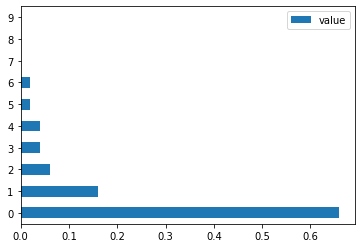

In [233]:
feature_importances(best_adaboost, X_train)

In [234]:
data = {'RESPONSE': AdaBoost_preds}
solution_df = pd.DataFrame(index=mailout_test_LNR, data=data)

In [235]:
solution_df

,RESPONSE
LNR,
1754,0.324211
1770,0.331880
1465,0.244490
1470,0.244490
1478,0.264398
...,...
67615,0.301359
67938,0.245387
67942,0.322365


In [236]:
solution_df.to_csv("./submissions/adaboost_s4.csv")